## Como implementar RAG

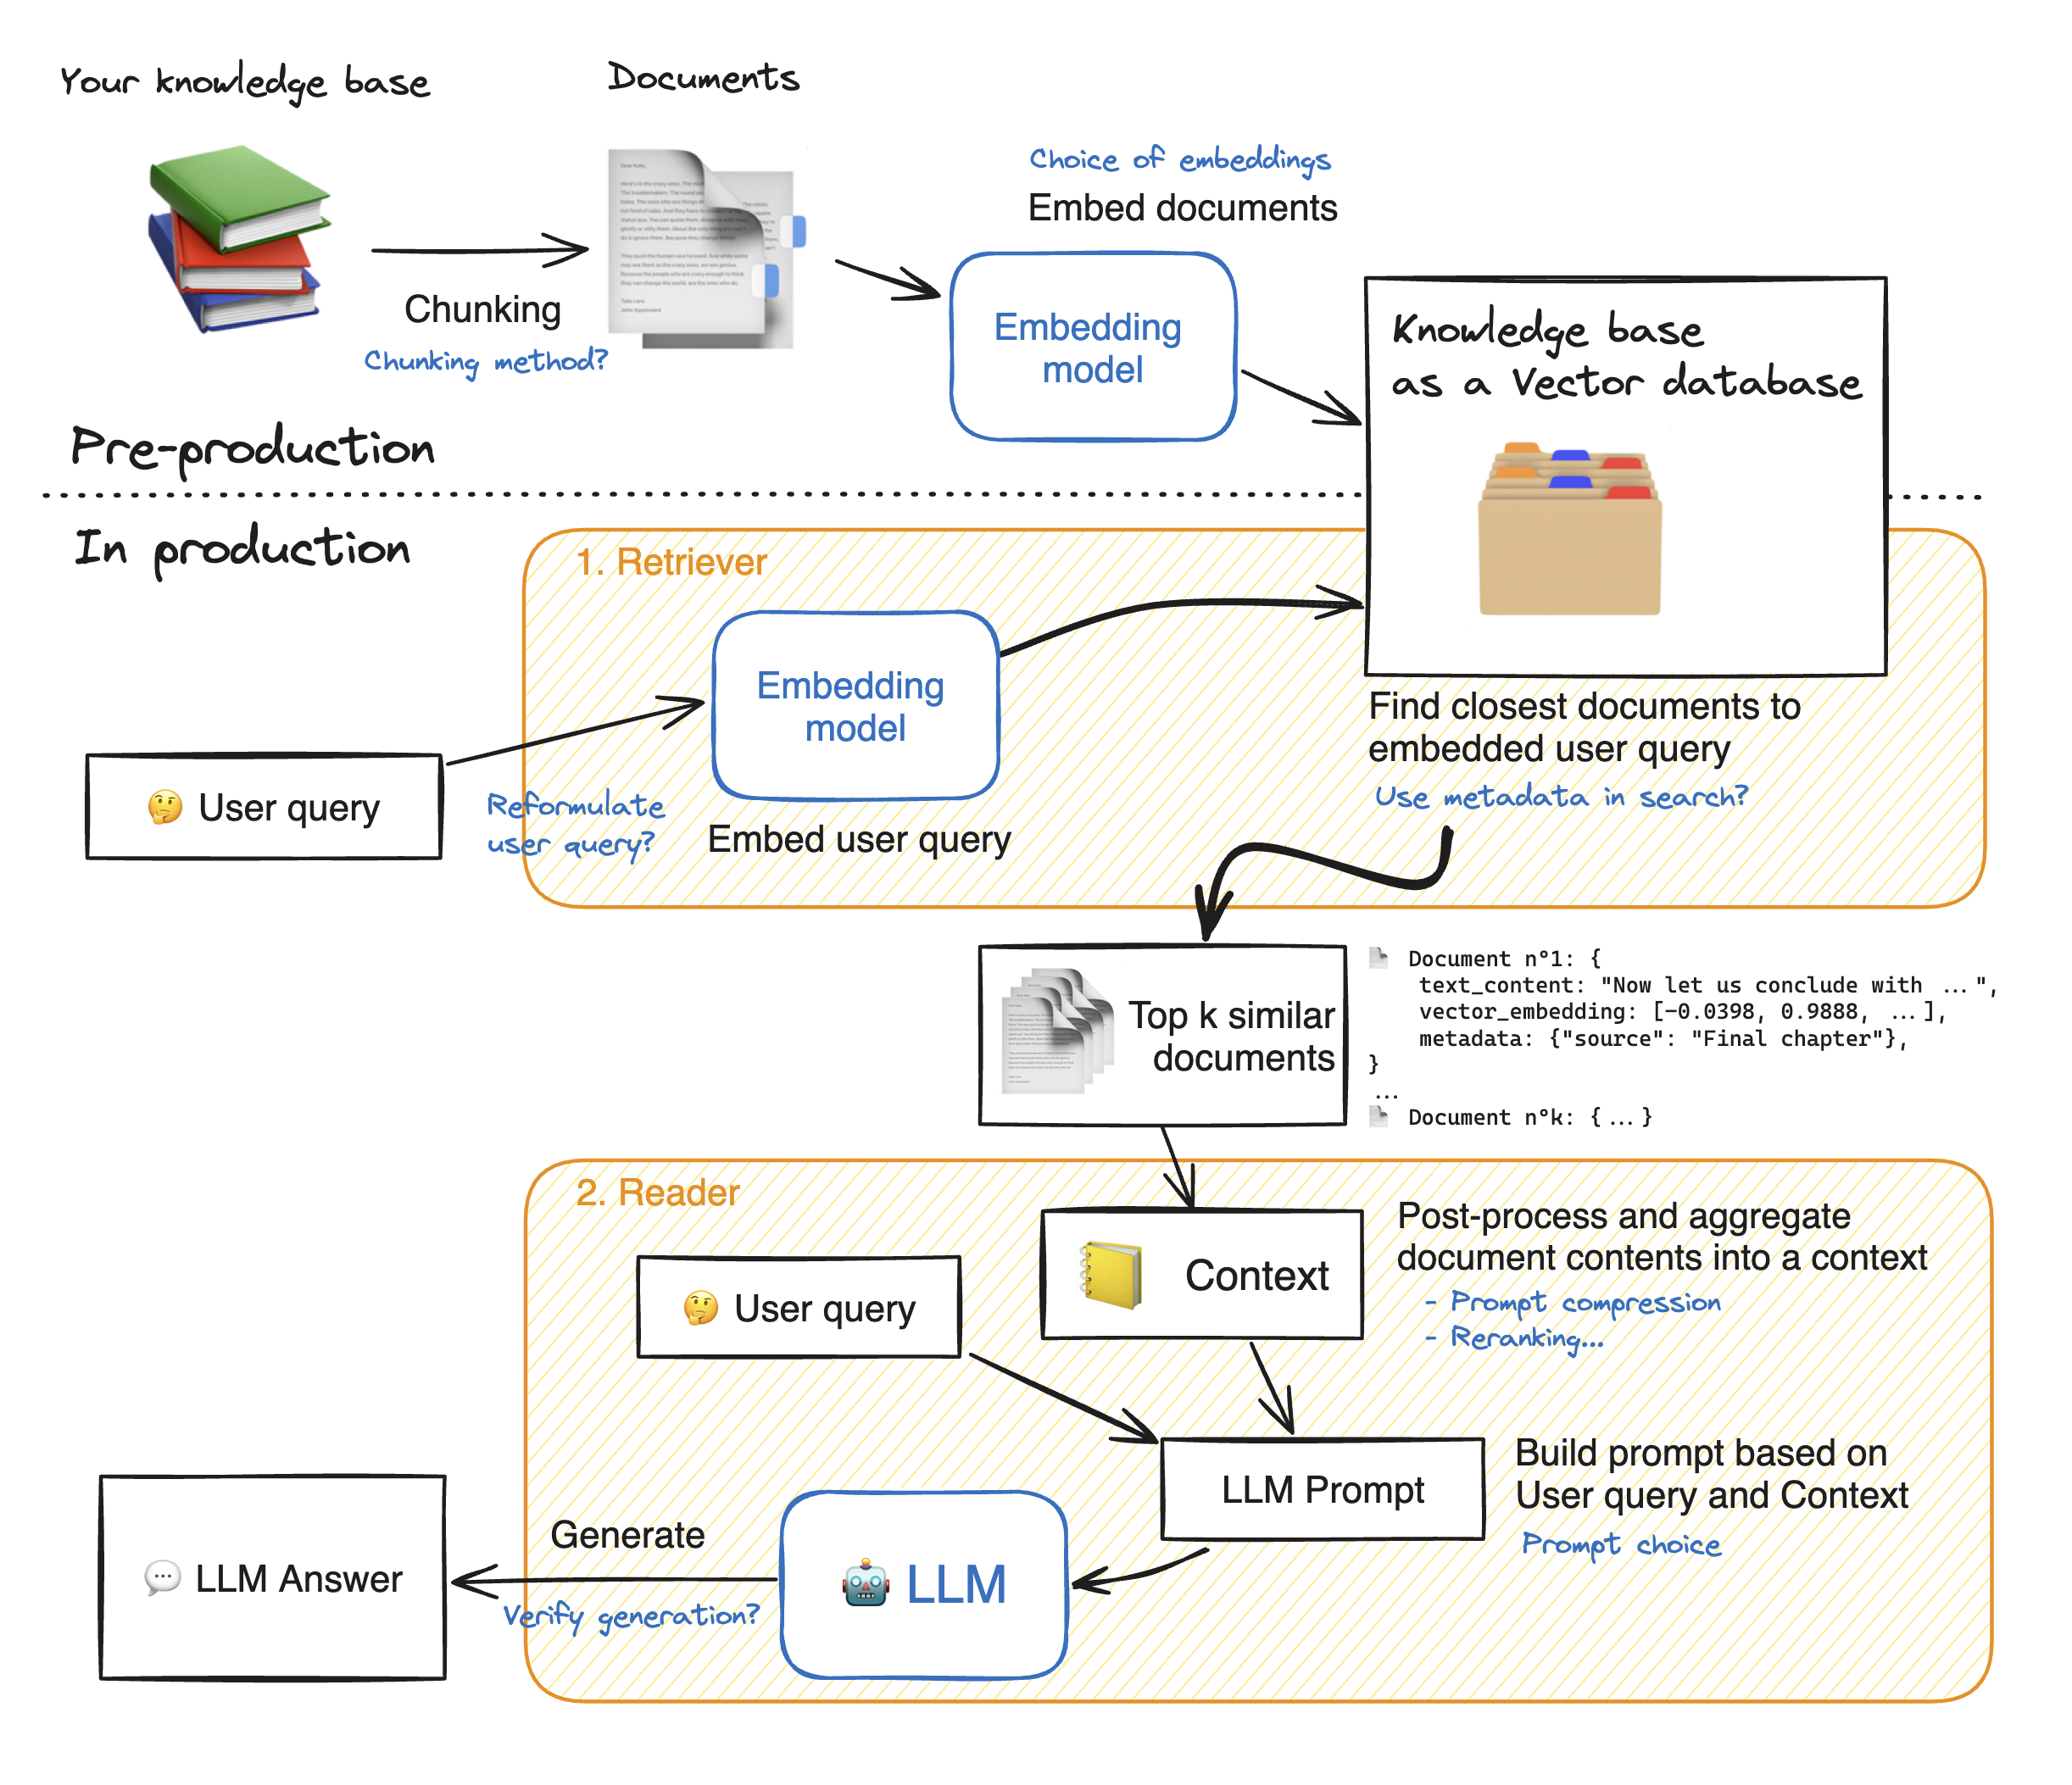

# 1: Dependencias y variables de entorno

In [1]:
!pip -q install chromadb langchain  langchain-community langchain-openai langchain-chroma pypdf tiktoken ragas langdetect

In [2]:
# Dependencias de Langchain
from langchain.document_loaders.pdf import PyPDFDirectoryLoader  # Importar cargador de PDFs desde Langchain
from langchain.text_splitter import RecursiveCharacterTextSplitter  # Importar separador de texto desde Langchain
from langchain_openai import AzureOpenAIEmbeddings  # Importar embeddings de OpenAI desde Langchain
from langchain.schema import Document  # Importar esquema Document desde Langchain
from langchain_chroma import Chroma  # Importar almacén vectorial Chroma desde Langchain
from langchain.prompts import PromptTemplate  # Importar plantilla de prompts desde Langchain
from langchain.chat_models import AzureChatOpenAI  # Importar modelo de chat de OpenAI desde Langchain
from langchain.evaluation import load_evaluator  # Importar evaluador desde Langchain
from langchain.prompts import ChatPromptTemplate  # Importar plantilla de prompts de chat
from langdetect import detect, LangDetectException
import tiktoken

from ragas import evaluate # Evaluar con RAG
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_precision,
    context_recall,
)
from datasets import Dataset

import os  # Importar módulo os para funcionalidades del sistema operativo
import shutil  # Importar módulo shutil para operaciones de archivos de alto nivel
from google.colab import files # Carga de archivos en Colab
import re # regex
from tqdm import tqdm
import pandas as pd # manejo de datos
import matplotlib.pyplot as plt # graficar
plt.style.use('ggplot')

import logging
logging.getLogger("pypdf").setLevel(logging.ERROR) # no mostrar warnings de preprocesamiento de pdfs

Para cargar nuestras herramientas como Embeddings y Modelos LLM (Chatbots), cargamos la API KEY que dará de alta como variables de entorno diversos valores necesarios para el despliegue y ejecución del proyecto

In [3]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
API_VERSION = userdata.get('OPENAI_API_VERSION')
AZURE_ENDPOINT = userdata.get('AZURE_OPENAI_ENDPOINT')

#print(type(OPENAI_API_KEY),OPENAI_API_KEY)
#print(type(API_VERSION),API_VERSION)
#print(type(AZURE_ENDPOINT),AZURE_ENDPOINT)

Otra opción pasaría por cargar desde un archivo externo tanto la API KEY, la versión y el endpoint para después crear las variables de entorno pertinentes.

No ejecutar las siguientes celdas.

In [4]:
## Posible adecuar funcion si viene en otro formato la API KEY
def load_api_key_from_txt():
    # Subir archivo manualmente
    uploaded = files.upload()
    filename = next(iter(uploaded))  # Obtener nombre del archivo subido

    # Leer archivo y extraer KEY y TARGET_URI
    with open(filename, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if "KEY=" in line:
                os.environ["OPENAI_API_KEY"] = line.strip().split("=", 1)[1]
            elif "TARGET_URI=" in line:
              start = line.find("://") + 3
              end = line.find("/", start)
              endpoint = line[11:end+1]
              os.environ['AZURE_OPENAI_ENDPOINT'] = endpoint
              version = line.strip().split("=")[-1]
              os.environ['OPENAI_API_VERSION'] = version

    # Mostrar resultado resumido
    print("API Key y configuración cargadas:")
    print("Clave:", os.environ['OPENAI_API_KEY'][:6] + "...")
    print("Base (Endpoint):", os.environ.get('AZURE_OPENAI_ENDPOINT'))
    print("Version:", os.environ.get('OPENAI_API_VERSION'))

In [5]:
#load_api_key_from_txt()

AzureOpenAIEmbeddings y AzureOpenAI, comúnmente solicitan que se definan estas variables de entorno.

- AZURE_OPENAI_API_KEY: Tu clave secreta de acceso al recurso Azure OpenAI.

- AZURE_OPENAI_ENDPOINT: La URL raíz de tu recurso, p. ej. https://midominio.openai.azure.com.

- AZURE_OPENAI_API_VERSION: La versión de la API que usarás, por ejemplo 2023-05-15.

- AZURE_OPENAI_DEPLOYMENT_NAME: El nombre de tu deployment de embeddings (p. ej. text-embedding-ada-002)

En AWS Bedrock (cuando usas Bedrock vía boto3 o el llamador de LangChain)

- AWS_SECRET_ACCESS_KEY:Tus credenciales IAM para autenticarte en AWS.

- AWS_REGION o AWS_DEFAULT_REGION: La región donde está habilitado Bedrock (p. ej. us-east-1).

- AWS_SESSION_TOKEN: Tu clave secreta de acceso al recurso

- JWT

[Codelabs](https://platform.bbva.com/codelabs/ai-architecture/Codelabs%20Arquitectura%20AI#/)

In [6]:
#api_key = os.environ['OPENAI_API_KEY']
#api_base = os.environ.get('AZURE_OPENAI_ENDPOINT')
#version = os.environ.get('OPENAI_API_VERSION')


# 2: Lectura de datos PDF

In [7]:
#uploaded = files.upload()

#!unzip data.zip -d ./data

In [8]:
DATA_PATH = r"data"

def load_documents():
    """
    Carga documentos PDF desde el directorio especificado utilizando PyPDFDirectoryLoader.

    Retorna:
        Lista de objetos Document: Documentos PDF cargados representados como objetos Document de Langchain.
    """
    document_loader = PyPDFDirectoryLoader(DATA_PATH)  # Inicializa el cargador de PDFs con el directorio especificado
    return document_loader.load()

In [9]:
documents = load_documents()
documents[:2]

[Document(metadata={'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20210317173944', 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf', 'total_pages': 15, 'page': 0, 'page_label': '1'}, page_content='107\nLas pruebas de estrés en los programas\nde evaluación del sistema financiero\nRoberto Blanco Escolar (*)\nAlicia García Herrero (*)\nEste artículo describe brevemente las principales características de \nlos programas de evaluación del sistema financiero del FMI y del Banco \nMundial, denominado FSAP , con especial atención a las pruebas de \nestrés, por ser estas uno de los pilares de dicho programa, a la vez que \nson utilizadas por bancos y reguladores con fines más generales. En \nconcreto, se describen los principales elementos del diseño de las \npruebas de estrés en el contexto de los FSAP y se revisa cómo se han \nespecificado dichas pruebas en los FSAP realizados hasta ahora en los \npaíses desarrollados. Se concluye que las pr

In [10]:
# Cada hoja de los pdf los convierte en un documento
# En este caso tenemos 2 documentos
type(documents), len(documents)

(list, 63)

In [11]:
documents[0]
# total_pages': 15 -> el primer documento tenemos 15 hojas

Document(metadata={'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20210317173944', 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf', 'total_pages': 15, 'page': 0, 'page_label': '1'}, page_content='107\nLas pruebas de estrés en los programas\nde evaluación del sistema financiero\nRoberto Blanco Escolar (*)\nAlicia García Herrero (*)\nEste artículo describe brevemente las principales características de \nlos programas de evaluación del sistema financiero del FMI y del Banco \nMundial, denominado FSAP , con especial atención a las pruebas de \nestrés, por ser estas uno de los pilares de dicho programa, a la vez que \nson utilizadas por bancos y reguladores con fines más generales. En \nconcreto, se describen los principales elementos del diseño de las \npruebas de estrés en el contexto de los FSAP y se revisa cómo se han \nespecificado dichas pruebas en los FSAP realizados hasta ahora en los \npaíses desarrollados. Se concluye que las pru

In [12]:
set([doc.metadata.get('source') for doc in documents])

{'data/data/analisis_impacto_pruebas_resistencia_financiero_esp.pdf',
 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf'}

In [13]:
#Metadata de la pagina
documents[45].metadata

{'producer': 'Apogee Prepress 7.0 Normalizer',
 'creator': 'QuarkXPress 9.5',
 'creationdate': '2013-06-10T17:30:24+02:00',
 'subject': 'Análisis de impacto de las pruebas de resistencia del sistema financiero',
 'author': 'Management Solutions',
 'keywords': 'Análisis de impacto de las pruebas de resistencia del sistema financiero',
 'moddate': '2013-08-06T14:36:59+02:00',
 'title': 'Análisis de impacto de las pruebas de resistencia del sistema financiero',
 'source': 'data/data/analisis_impacto_pruebas_resistencia_financiero_esp.pdf',
 'total_pages': 48,
 'page': 30,
 'page_label': '31'}

In [14]:
documents[0].metadata

# Ojo que para cada documento (pagina de pdfs) cada uno puede tener diferente metadata detectada automaticamente.

{'producer': 'PDFium',
 'creator': 'PDFium',
 'creationdate': 'D:20210317173944',
 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf',
 'total_pages': 15,
 'page': 0,
 'page_label': '1'}

La cantidad de documentos aumenta porque genera un "document" por cada página, esto se puede adecuar según objetivos.

En los metadatos se guarda el origen del "documento"

# 3: Dividir en fragmentos de texto



 Existen varias estrategias de **troceado:**

 - Solapamiento (overlap).
 - Por páginas. -> En este ejemplo, la libreria de Langchain ya lo divide por paginas
 - Por párrafos.
 - Por secciones.
 - Sin solapamiento (no overlap).

### Troceado con overlap (solapamiento estándar)



El troceado con overlap es útil cuando se requiere mantener contexto entre fragmentos, evitando la pérdida de información relevante en los bordes del texto.

In [15]:
def split_with_overlap(documents: list[Document], chunk_size=600, chunk_overlap=150):
    splitter = RecursiveCharacterTextSplitter(
                        chunk_size=chunk_size,
                        chunk_overlap=chunk_overlap,
                        length_function=len, #Como se mide la longitud del fragmento (chunk size), en este caso por caracteres
                        add_start_index=True
                    )
    chunks = splitter.split_documents(documents)
    print(f"Se dividieron {len(documents)} documentos en {len(chunks)} fragmentos (chunks).")
    return chunks #splitter.split_documents(documents)

#Para distintos tipos de reportes, en general se utilizan distintos tipos de chunkoverlap
#La idea es tener una grilla de pruebas de chunk_size y de chunk_overlap por tipos de documentos distintos
#Evaluar por RAGA las 4 metricas mas relevantes unas cuantas veces y obtener un promedio
#Comenzar el ciclo de evaluacion con una muestra de N docs que sea un porcentaje del total, para no demorar tanto.
#Ojo que en esto, cada documento es una pagina, por lo tanto, el chunking y overlap se aplicara sobre una pagina


### Troceado por página (sin dividir, una página por chunk)



El troceado por página es útil cuando cada página del documento contiene ideas completas y autocontenidas, como en manuales, sentencias legales o informes técnicos. Esta estrategia preserva la estructura original del documento, lo que facilita tareas de recuperación estructurada o visualización contextual.

In [16]:
def split_by_page(documents: list[Document]):
    # No hay división: se asume que cada documento es una página
    print(f"Se dividieron {len(documents)} documentos en {len(documents)} fragmentos (chunks).")
    return documents

### Troceado por párrafos (separador "\n\n")



El troceado por párrafos (usando el separador "\n\n") es útil cuando se busca dividir el texto en unidades semánticas coherentes, ya que cada párrafo suele representar una idea completa. Esta estrategia mejora la calidad de los embeddings al conservar el contexto local sin cortar en medio de una oración, y es especialmente efectiva en textos argumentativos, artículos o normativas.

In [17]:
def split_by_paragraph(documents: list[Document]):
    splitter = RecursiveCharacterTextSplitter(
                        chunk_size=1000,
                        chunk_overlap=0,
                        separators=["\n\n"],
                        add_start_index=True
                    )
    # Dividir los documentos en fragmentos más pequeños usando el divisor de texto
    chunks = splitter.split_documents(documents)
    print(f"Se dividieron {len(documents)} documentos en {len(chunks)} fragmentos (chunks).")

    return chunks

### Troceado por secciones largas (e.g., títulos o saltos triples)



El troceado por secciones largas, como aquellas delimitadas por títulos o saltos de línea triples (\n\n\n), permite dividir el texto respetando su estructura jerárquica, como capítulos, artículos o encabezados. Preservar estas divisiones mejora la coherencia semántica del contenido dentro de cada chunk y facilita tareas como búsqueda contextual o recuperación aumentada.

In [18]:
def split_by_sections(documents: list[Document]):
    splitter = RecursiveCharacterTextSplitter(
                        chunk_size=2000,
                        chunk_overlap=0,
                        separators=["\n\n\n", "\n\n"],
                        add_start_index=True
                    )
    chunks = splitter.split_documents(documents)
    print(f"Se dividieron {len(documents)} documentos en {len(chunks)} fragmentos (chunks).")

    return chunks

### Troceado sin solapamiento (chunks independientes)


El troceado sin solapamiento divide el texto en fragmentos consecutivos de tamaño fijo, sin repetir contenido entre ellos. Esta estrategia es más eficiente computacionalmente, ya que genera menos fragmentos y reduce la redundancia.

In [19]:
#Razones para no hacer overlap: Tengo secciones cortas, otras
def split_no_overlap(documents: list[Document], chunk_size=600):
    splitter = RecursiveCharacterTextSplitter(
                        chunk_size=chunk_size,
                        chunk_overlap=0,
                        length_function=len,
                        add_start_index=True #Mostrar donde es el inicio y el final
                    )
    chunks = splitter.split_documents(documents)
    print(f"Se dividieron {len(documents)} documentos en {len(chunks)} fragmentos (chunks).")

    return chunks

### Comparativa resultados

Utilizaremos diversas estrategias para comparar sus resultados más adelante

In [20]:
print('split_by_page :\n')
chunks_by_page = split_by_page(documents)
print(f'*'*15)
print('split_by_paragraph :\n')
chunks_by_paragraph = split_by_paragraph(documents)
print(f'*'*15)
print('split_by_sections :\n')
chunks_by_sections = split_by_sections(documents)
print(f'*'*15)
print('split_no_overlap :\n')
chunks_no_overlap = split_no_overlap(documents)
print(f'*'*15)
print('split_with_overlap :\n')
chunks_with_overlap = split_with_overlap(documents)
print(f'*'*15)

split_by_page :

Se dividieron 63 documentos en 63 fragmentos (chunks).
***************
split_by_paragraph :

Se dividieron 63 documentos en 62 fragmentos (chunks).
***************
split_by_sections :

Se dividieron 63 documentos en 62 fragmentos (chunks).
***************
split_no_overlap :

Se dividieron 63 documentos en 358 fragmentos (chunks).
***************
split_with_overlap :

Se dividieron 63 documentos en 428 fragmentos (chunks).
***************


Confirmamos cómo quedan algunos de los trozos aplicando una técnica en concreto.

In [21]:
len(chunks_with_overlap)

428

In [22]:
for chunk in chunks_with_overlap[10:15]:
    print(chunk)
    print("\n")

page_content='bros de dichas instituciones. Sus objetivos principales son reforzar el 
control y reducir la vulnerabilidad de los sistemas financieros, así como 
promover el desarrollo de los mismos en el contexto del trabajo del Ban-
co Mundial en países emergentes y con bajos ingresos (1).
Para ello se cuenta con personal del FMI y del Banco Mundial, así 
como con expertos de instituciones colaboradoras. En la actualidad, más 
de 75 instituciones públicas nacionales, principalmente bancos centrales 
y agencias supervisoras, así como otros organismos internacionales, han' metadata={'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20210317173944', 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf', 'total_pages': 15, 'page': 1, 'page_label': '2', 'start_index': 1725}


page_content='de 75 instituciones públicas nacionales, principalmente bancos centrales 
y agencias supervisoras, así como otros organismos internacionales, han 
cedido perso

In [23]:
chunks_with_overlap[1].metadata

{'producer': 'PDFium',
 'creator': 'PDFium',
 'creationdate': 'D:20210317173944',
 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf',
 'total_pages': 15,
 'page': 0,
 'page_label': '1',
 'start_index': 416}

In [24]:
chunks_with_overlap[2].page_content

'nanciero a potenciales perturbaciones y que su utilidad no se limita so-\nlamente a los FSAP .\n1. INTRODUCCIÓN\nEl elevado número de crisis financieras desde la segunda mitad de los \nnoventa, especialmente en países emergentes, ha puesto de relieve cuán \nimportante es que el sistema financiero sea sólido para la estabilidad \nmacroeconómica de un país y, en un mundo cada vez más integrado, \npara el orden financiero internacional, especialmente en el caso de paí-\nses de importancia sistémica.\nEn este contexto, en 1999 el Fondo Monetario Internacional (FMI) y el'

Prueba a cambiar la técnica de partición y observa las diferencias.

In [25]:
# Escribe tu respuesta aquí
print(chunks_by_paragraph[7].metadata,'\n')
chunks_by_paragraph[7].page_content

{'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20210317173944', 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf', 'total_pages': 15, 'page': 7, 'page_label': '8', 'start_index': 0} 



'BANCO DE ESPAÑA, ESTABILIDAD FINANCIERA, NÚM. 6\n114\nLas herramientas analíticas que se utilizan en las pruebas de estrés \ndependen del tipo de análisis que se realiza y de los modelos que dispo-\nnen las autoridades nacionales. En el caso de los análisis de escenarios, \nlos bancos centrales utilizan sus modelos macroeconómicos para evaluar \nel impacto de una variable exógena sobre un conjunto de variables ma-\ncroeconómicas y financieras. No obstante, debe advertirse que estos \nmodelos están normalmente diseñados para un objetivo distinto, que es \nel de obtener proyecciones macroeconómicas en condiciones no extre-\nmas. De hecho, los parámetros de este tipo de modelos se han estimado \na partir de las relaciones estadísticas normales observadas entre las va-\nriables. La existencia de efectos no lineales podría llevar a infravalorar el \nimpacto de perturbaciones extremas.\nPor otra parte, los modelos macroeconómicos no proporcionan pro-\nyecciones de algunas variables relevant

# 4 Limpieza y metadatado de texto





## 4.1 Limpieza
Esto DEBE hacerse ANTES del Chunking, en este notebook viene despues, pero esto no tiene sentido.

Una vez realizado el proceso de fragmentación de los documentos originales atendiendo a múltiples criterios, pasamos a limpiar los textos extraídos. De esta manera evitamos distorsionar el contexto original.

La limpieza de textos ha de inlcuir entre otras cosas:

- Normalización de espacios y saltos de línea(re.sub(r'\s+', ' ', text)).
- Eliminación de headers/footers comunes (“Página 1”, “Artículo 2”, “Capítulo I” al inicio de fragmentos).
- Borrado de tokens no textuales (p. ej. artefactos OCR).
- Eliminación de caracteres no UTF-8 válidos.


COMENTARIO: Hoy se esta utilizando mucho un LLM para limpiar el lenguaje, en lugar de regular expressions

In [26]:
def normalize_document_text(chunk: Document) -> Document:
  """
  Limpia el contenido de un objeto Document eliminando saltos de línea innecesarios
  y espacios duplicados.
  Args:
      chunk (Document): Fragmento de texto tipo LangChain Document.

  Returns:
      Document: Nuevo chunk limpio con los mismos metadatos.
  """
  text = chunk.page_content

  # Limpieza básica
  text = re.sub(r"\n{3,}", "\n\n", text)        # Normaliza saltos de línea múltiples
  text = re.sub(r"[ \t]+", " ", text)           # Elimina espacios duplicados
  text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)  # Convierte saltos simples a espacios
  text = text.strip()                           # Quita espacios al inicio y final

  return Document(page_content=text, metadata=chunk.metadata)

Podemos aplicar esta limpieza a cada uno de los fragmentos de cada una de las estrategias de troceado.

In [27]:
chunks_normalized = [normalize_document_text(c) for c in chunks_with_overlap]

In [28]:
chunks_normalized[0]

Document(metadata={'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20210317173944', 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf', 'total_pages': 15, 'page': 0, 'page_label': '1', 'start_index': 0}, page_content='107 Las pruebas de estrés en los programas de evaluación del sistema financiero Roberto Blanco Escolar (*) Alicia García Herrero (*) Este artículo describe brevemente las principales características de  los programas de evaluación del sistema financiero del FMI y del Banco  Mundial, denominado FSAP , con especial atención a las pruebas de  estrés, por ser estas uno de los pilares de dicho programa, a la vez que  son utilizadas por bancos y reguladores con fines más generales. En  concreto, se describen los principales elementos del diseño de las')

In [29]:
chunks_normalized[0].page_content

'107 Las pruebas de estrés en los programas de evaluación del sistema financiero Roberto Blanco Escolar (*) Alicia García Herrero (*) Este artículo describe brevemente las principales características de  los programas de evaluación del sistema financiero del FMI y del Banco  Mundial, denominado FSAP , con especial atención a las pruebas de  estrés, por ser estas uno de los pilares de dicho programa, a la vez que  son utilizadas por bancos y reguladores con fines más generales. En  concreto, se describen los principales elementos del diseño de las'

Se pueden realizar múltiples iteraciones de limpieza sobre los distintos fragmentos y analizar los resultados.

In [30]:
def strip_legal_headers(chunk: Document) -> Document:
  """
  Elimina encabezados visuales y numeraciones irrelevantes en documentos legales,
  pero conserva secciones jurídicas como artículos, capítulos y títulos.

  ruby
  Copiar
  Editar
  Args:
      chunk (Document): Objeto LangChain Document.

  Returns:
      Document: Nuevo fragmento limpio.
  """
  text = chunk.page_content

  # Eliminar líneas tipo "Página 1", "Página 22"
  text = re.sub(r"(?i)^\s*p[áa]gina\s+\d+\s*$", "", text, flags=re.MULTILINE)

  # Eliminar líneas tipo "BOE núm. 123", "DOF No. 321"
  text = re.sub(r"(?i)^\s*(BOE|DOF|Diario Oficial|DOGV|Gaceta)\s*(n[úu]m\.?|no\.?)?\s*\d+.*$", "", text, flags=re.MULTILINE)

  # Eliminar líneas tipo "Documento generado el..."
  text = re.sub(r"(?i)^.*(generado el|descargado el|emitido el)\s+\d{1,2}/\d{1,2}/\d{2,4}.*$", "", text, flags=re.MULTILINE)

  # Eliminar líneas vacías múltiples consecutivas
  text = re.sub(r"\n{3,}", "\n\n", text)


  # Recortar espacios al principio y final
  text = text.strip()

  return Document(page_content=text, metadata=chunk.metadata)

In [31]:
chunks_cleaned = [strip_legal_headers(c) for c in chunks_normalized]

In [32]:
chunks_cleaned[1]

Document(metadata={'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20210317173944', 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf', 'total_pages': 15, 'page': 0, 'page_label': '1', 'start_index': 416}, page_content='son utilizadas por bancos y reguladores con fines más generales. En  concreto, se describen los principales elementos del diseño de las  pruebas de estrés en el contexto de los FSAP y se revisa cómo se han  especificado dichas pruebas en los FSAP realizados hasta ahora en los  países desarrollados. Se concluye que las pruebas de estrés son una  herramienta útil para evaluar la capacidad de resistencia del sistema fi- nanciero a potenciales perturbaciones y que su utilidad no se limita so- lamente a los FSAP . 1. INTRODUCCIÓN')

In [33]:
chunks_cleaned[1].page_content

'son utilizadas por bancos y reguladores con fines más generales. En  concreto, se describen los principales elementos del diseño de las  pruebas de estrés en el contexto de los FSAP y se revisa cómo se han  especificado dichas pruebas en los FSAP realizados hasta ahora en los  países desarrollados. Se concluye que las pruebas de estrés son una  herramienta útil para evaluar la capacidad de resistencia del sistema fi- nanciero a potenciales perturbaciones y que su utilidad no se limita so- lamente a los FSAP . 1. INTRODUCCIÓN'

Podemos optar por crear una función que permita el encadenamiento de diferentes etapas de limpieza.

In [34]:
def clean_chunks(chunk: Document) -> Document:
  """
  Orquestación de múltiples funciones de limpieza.

  Args:
      chunk (Document): Objeto LangChain Document.
  Returns:
      Document: Nuevo fragmento limpio."""

  for cleaner in [normalize_document_text, strip_legal_headers]:
    chunk = cleaner(chunk)

  return chunk



In [35]:
cleaned_chunks_no_overlap = [clean_chunks(chunk) for chunk in chunks_no_overlap]
cleaned_chunks_no_overlap[1].page_content

'pruebas de estrés en el contexto de los FSAP y se revisa cómo se han  especificado dichas pruebas en los FSAP realizados hasta ahora en los  países desarrollados. Se concluye que las pruebas de estrés son una  herramienta útil para evaluar la capacidad de resistencia del sistema fi- nanciero a potenciales perturbaciones y que su utilidad no se limita so- lamente a los FSAP . 1. INTRODUCCIÓN El elevado número de crisis financieras desde la segunda mitad de los  noventa, especialmente en países emergentes, ha puesto de relieve cuán'

In [36]:
cleaned_chunks_no_overlap[1].metadata

{'producer': 'PDFium',
 'creator': 'PDFium',
 'creationdate': 'D:20210317173944',
 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf',
 'total_pages': 15,
 'page': 0,
 'page_label': '1',
 'start_index': 553}

¿Alguno más que sugieran un paso adicional de limpieza? p.e. eliminar  la c de company

In [37]:
# Escribe tu respuesta aquí
re.sub(r"-\n", "", cleaned_chunks_no_overlap[1].page_content)
# Quitar los saltos de renglón, (el guíon de que en el texto corto la palabra en le renglón de abajo)

'pruebas de estrés en el contexto de los FSAP y se revisa cómo se han  especificado dichas pruebas en los FSAP realizados hasta ahora en los  países desarrollados. Se concluye que las pruebas de estrés son una  herramienta útil para evaluar la capacidad de resistencia del sistema fi- nanciero a potenciales perturbaciones y que su utilidad no se limita so- lamente a los FSAP . 1. INTRODUCCIÓN El elevado número de crisis financieras desde la segunda mitad de los  noventa, especialmente en países emergentes, ha puesto de relieve cuán'

## 4.2 Metadatos



Los metadatos bien definidos fortalecen todo el flujo de RAG: al etiquetar cada fragmento con atributos como fecha, categoría o fuente, podemos filtrar y priorizar la recuperación, descartar información obsoleta, mantener trazabilidad de los orígenes y enriquecer el prompt con contexto preciso (por ejemplo “publicado en 2024” o “sección Casos de Uso”), lo cual reduce ambigüedades, mejora la calidad y coherencia de las respuestas, y aporta transparencia y control sobre el contenido que el modelo emplea.

Por ejemplo, podemos complementar los metadatos extrayendo tanto el título del documento como el tipo de documento del que se trata (txt, pdf, csv, etcétera).

**Nota**: Es clave definir cuales son los campos de metadata relevante, porque estos luego ayudan a filtrar los vectores de embedding.

In [38]:
#Esto porque eventualmente me podria interesar filtrar para que traiga solo documentos pdf o solo csv, etc
def extract_title_and_extension_from_source(doc: Document):
    """
    Extrae título y lenguaje del nombre de fichero de doc.metadata["source"].
    Asume un patrón como 'es_MiTitulo.pdf' o 'en_GuideToRAG.txt'.
    """
    source = doc.metadata.get("source", "")
    filename = os.path.basename(source)
    m = re.match(r'^(?P<title>.+)\.(?P<ext>[a-zA-Z0-9]+)$', filename)

    if m:
        title = m.group("title")
        extension = m.group("ext").lower()
    else:
        title = os.path.splitext(filename)[0]
        extension = None
    return title, extension



Como podemos aplicar distintas funciones de metadatado, creamos una función que aglutine las distintas llamadas a estas funciones, para adoptar un diseño modular.

In [39]:
#Se agrega metadata relevante al objeto de documento
#Otro ejemplo de metadata relevante, puede ser identificar docs que comiencen con "Reporte"
def enrich_documents_with_extracted_metadata(docs):
    enriched = []
    for doc in docs:
        title, extension = extract_title_and_extension_from_source(doc)
        meta = dict(doc.metadata or {})
        meta.update({"title": title, "file": extension})
        enriched.append(
            Document(page_content=doc.page_content, metadata=meta)
        )
    return enriched

In [40]:
enriched_docs = enrich_documents_with_extracted_metadata(chunks_cleaned)

for d in enriched_docs[:2]:
    print(d.metadata)

{'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20210317173944', 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf', 'total_pages': 15, 'page': 0, 'page_label': '1', 'start_index': 0, 'title': 'pruebas_estres_programas_evaluacion_sistema_financiero_esp', 'file': 'pdf'}
{'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20210317173944', 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf', 'total_pages': 15, 'page': 0, 'page_label': '1', 'start_index': 416, 'title': 'pruebas_estres_programas_evaluacion_sistema_financiero_esp', 'file': 'pdf'}


---
A su vez, podemos enriquecer aún más los metadatos detectando el lenguaje del documento en base al contexto y el número de tokens de que consta cada uno de los fragmentos.







In [41]:
def detect_language_from_content(doc: Document) -> str:
    """
    Detecta el lenguaje del contenido textual de un Document usando langdetect.
    Retorna el código de idioma (ej. 'es', 'en').
    """
    try:
        return detect(doc.page_content)
    except LangDetectException:
        return None

Igualmente puede ser interesante dejar registro en los metadatos del número de tokens que contiene cada porción del documento troceado.

In [42]:

def num_tokens(text: str, model: str = "gpt-4o") -> int:
      """
      Cuenta el número de tokens en un texto dado en base al modelo LLM específico.

      Args:
          text (str): Cadena de texto.
          model (str, optional): Modelo LLM. Valor por defecto: "gpt-4o".

      Returns:
          int: El número total de tokens en el texto para el modelo LLM especificado.
    """
      encoding = tiktoken.encoding_for_model(model)
      return len(encoding.encode(text))

De esta manera podemos enriquecer los metadatos que acompañarán al fragmento de texto.  


In [43]:
#Funcion nueva que agrega nuevos metadatos
def enrich_documents_with_extracted_metadata(docs: list[Document], model: str = "gpt-4o"):
    """
      Itera sobre cada documento y añade meta información (título, idioma extraído del nombre del archivo fuente, el idioma detectado
      del contenido del texto y número de tokens).

      Args:
          docs (list[Document]): Una lista de objetos Document de Langchain ('page_content' y 'metadata').
          model (str): Modelo LLM. Por ejemplo: "gpt-4o".

      Returns:
          list[Document]: Lista de objetos Document de Langchain, con metadatos enriquecidos.
    """
    enriched = []
    for doc in docs:

        title, extension = extract_title_and_extension_from_source(doc)
        language = detect_language_from_content(doc)
        num_token = num_tokens(doc.page_content, model=model)

        meta = dict(doc.metadata or {})
        meta.update({"title": title,
                     "language":language,
                     'file':extension ,
                     "num_tokens":num_token})
        enriched.append(
            Document(page_content=doc.page_content, metadata=meta)
        )
    return enriched

In [44]:
enriched_docs = enrich_documents_with_extracted_metadata(cleaned_chunks_no_overlap, "gpt-4o")
for d in enriched_docs[:2]:
    print(d.metadata)

{'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20210317173944', 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf', 'total_pages': 15, 'page': 0, 'page_label': '1', 'start_index': 0, 'title': 'pruebas_estres_programas_evaluacion_sistema_financiero_esp', 'language': 'es', 'file': 'pdf', 'num_tokens': 103}
{'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20210317173944', 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf', 'total_pages': 15, 'page': 0, 'page_label': '1', 'start_index': 553, 'title': 'pruebas_estres_programas_evaluacion_sistema_financiero_esp', 'language': 'es', 'file': 'pdf', 'num_tokens': 119}


Si se te ocurre alguno más, impleméntalo a continuación (categoría temática, sección original del documento, nivel de confidencialidad, etc.).

*Aquí puede invocarse a modelos LLM que ayuden a categorizar, resumir, ...*

In [45]:
#LLM deberia leer el chunk de texto e inferir el tema del cual habla el parrafo.

#Chunks with no overlap -> Created from original doc: Page of a PDF
#print("Chunk example:")
#print(enriched_docs[0].page_content)



'107 Las pruebas de estrés en los programas de evaluación del sistema financiero Roberto Blanco Escolar (*) Alicia García Herrero (*) Este artículo describe brevemente las principales características de  los programas de evaluación del sistema financiero del FMI y del Banco  Mundial, denominado FSAP , con especial atención a las pruebas de  estrés, por ser estas uno de los pilares de dicho programa, a la vez que  son utilizadas por bancos y reguladores con fines más generales. En  concreto, se describen los principales elementos del diseño de las'

In [88]:
from langchain_openai import AzureChatOpenAI


#LLM para limpiar datos
llm_metadata = AzureChatOpenAI(azure_deployment="gpt-4o",
    api_key = OPENAI_API_KEY,
    api_version=API_VERSION,
    azure_endpoint=AZURE_ENDPOINT,
    temperature=0.1,
    max_tokens=60, #Se restringe a 60 para topearlo, solamente quiero una tag de topic.
    timeout=None,
    max_retries=2)


In [99]:
def classify_content_llm(doc: Document, llm_metadata) -> str:
    prompt = f"""
    Clasifica el tema principal del siguiente fragmento de texto en una categoría.
    No incluyas detalles ni descriptivos, solamente la categoría.
    Texto: {doc.page_content}

    Categoría:
    """

    response = llm_metadata.invoke([{
        "role": "user",
        "content": prompt
    }])

    return response.content



In [100]:
#Funcion nueva que agrega nuevos metadatos
def enrich_documents_with_extracted_metadata(docs: list[Document], model: str = "gpt-4o"):
    """
      Itera sobre cada documento y añade meta información (título, idioma extraído del nombre del archivo fuente, el idioma detectado
      del contenido del texto y número de tokens).

      Args:
          docs (list[Document]): Una lista de objetos Document de Langchain ('page_content' y 'metadata').
          model (str): Modelo LLM. Por ejemplo: "gpt-4o".

      Returns:
          list[Document]: Lista de objetos Document de Langchain, con metadatos enriquecidos.
    """
    enriched = []
    for doc in docs:

        title, extension = extract_title_and_extension_from_source(doc)
        language = detect_language_from_content(doc)
        num_token = num_tokens(doc.page_content, model=model)

        category=classify_content_llm(doc, llm_metadata)

        meta = dict(doc.metadata or {})

        meta.update({"title": title,
                     "language":language,
                     'file':extension ,
                     "num_tokens":num_token,
                     "category": category})
        enriched.append(
            Document(page_content=doc.page_content, metadata=meta)
        )
    return enriched

In [101]:
#Loop de limpieza
enriched_docs = enrich_documents_with_extracted_metadata(chunks_cleaned)

In [102]:
#Revisamos la metadata del primer documento
enriched_docs[0].metadata

{'producer': 'PDFium',
 'creator': 'PDFium',
 'creationdate': 'D:20210317173944',
 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf',
 'total_pages': 15,
 'page': 0,
 'page_label': '1',
 'start_index': 0,
 'title': 'pruebas_estres_programas_evaluacion_sistema_financiero_esp',
 'language': 'es',
 'file': 'pdf',
 'num_tokens': 103,
 'category': 'Finanzas.'}

In [103]:
#Revisar las categorias
set([doc.metadata.get('category') for doc in enriched_docs])

{'    Regulación financiera',
 'Acuerdos internacionales',
 'Consultoría empresarial',
 'Corporativo/Empresarial',
 'Econometría.',
 'Economía',
 'Economía / Finanzas',
 'Economía y Finanzas',
 'Economía y finanzas',
 'Economía.',
 'Economía/Banca',
 'Economía/Finanzas',
 'Estabilidad financiera.',
 'Estadística y análisis de datos',
 'Fechas y países.',
 'Finanzas',
 'Finanzas / Modelización econométrica',
 'Finanzas y gestión de riesgos',
 'Finanzas y regulación bancaria',
 'Finanzas.',
 'Finanzas/Banca',
 'Finanzas/Economía',
 'Geografía.',
 'Gestión de riesgos',
 'Gestión de riesgos financieros',
 'Gestión de riesgos.',
 'Gestión empresarial y financiera',
 'Gestión financiera.',
 'Indeterminado',
 'Macroeconomía',
 'Metodología financiera.',
 'Metodología.',
 'Negocios',
 'Negocios y Consultoría',
 'Propiedad intelectual y derechos de autor',
 'Regulación financiera',
 'Regulación financiera.',
 'Sector financiero.',
 'Servicios financieros y consultoría.',
 'Sistema financiero.',

# 5: Guardar en una base de datos vectorial utilizando Chroma



Chroma es una base de datos de vectores open-source diseñada para almacenar y consultar embeddings generados por modelos de lenguaje o visión. https://docs.trychroma.com/

Guardar los vectores en una base de datos especializada como Chroma permite aprovechar su optimización para búsquedas de similitud a gran escala: al indexar cada fragmento de texto como un punto en un espacio vectorial, Chroma construye estructuras de datos (ej. HNSW) que reducen drásticamente el tiempo de consulta de vecinos más cercanos, garantizando respuestas semánticamente relevantes en milisegundos. Además, al persistir los vectores en disco y mantener metadatos asociados (como IDs de documento o posiciones de chunk), se facilita la actualización incremental del índice —agregando, modificando o eliminando embeddings sin reconstruir todo— y se asegura la durabilidad de los datos entre sesiones de notebook, lo cual es esencial para sistemas de RAG en producción.



## Integración LLM en el Banco



Base de datos vectorial: **OpenSearch**.

La base de datos vectorial es el backbone del RAG, dentro de ella se almacena el conocimiento en forma de embeddings, permitiendo su recuperación a través de las capacidades de búsqueda vectorial.  Opensearch  preserva un buen balance entre funcionalidad, performance y costes; ya que se trata de una alternativa totalmente serverless.

Mayor información en la [Documentación BBVA AI Architecture](https://platform.bbva.com/ai-architecture/documentation/1MimupcB9zEfpPlxItmcmYQxH2FTo_2vaMaFeCiRglBM/arquitectura-de-referencia/arquitectura-genai/arquitectura-tecnica)


## Seleccion del Embeddings



A continuación mostramos una pequeña tabla comparativa de embeddings

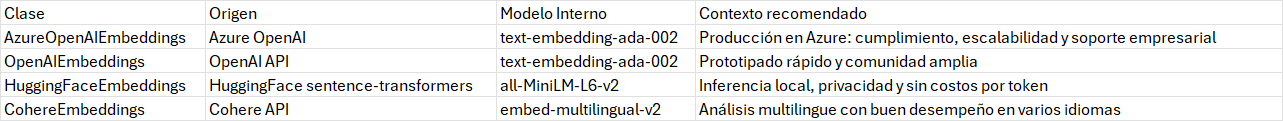

El embedding es la transformación fundamental que convierte texto en puntos en un espacio matemático donde “la distancia” refleja cuán cercanos están dos conceptos en significado.

*Dependiendo del modelo va con una u otra api version.*

## Creación BBDD

Vamos a crear tantas bases de datos como estrategias de partición hemos realizado. Posteriormente analizaremos cual de las distintas estrategias ofrece mejores resultados.

In [46]:
CHROMA_PATH = "/content/chroma_" # Crear carpeta llamada chroma en Archivos en funcion del tipo de trozeado

In [47]:
chunks_by_page = split_by_page(documents)
chunks_by_paragraph = split_by_paragraph(documents)
chunks_by_sections = split_by_sections(documents)
chunks_no_overlap = split_no_overlap(documents)
chunks_with_overlap = split_with_overlap(documents)

all_chunks = [chunks_with_overlap, chunks_no_overlap, chunks_by_page, chunks_by_paragraph, chunks_by_sections]

Se dividieron 63 documentos en 63 fragmentos (chunks).
Se dividieron 63 documentos en 62 fragmentos (chunks).
Se dividieron 63 documentos en 62 fragmentos (chunks).
Se dividieron 63 documentos en 358 fragmentos (chunks).
Se dividieron 63 documentos en 428 fragmentos (chunks).


Creamos las distintas particiones de los documentos en base a las diferentes técnicas aplicadas. En este paso, vamos a aplicar el troceado de los documentos y a la vez tanto limpiamos el fragmento como enriquecemos los metadatos asociados.

In [48]:
cleaned_chunks_overlap = enrich_documents_with_extracted_metadata([clean_chunks(chunk) for chunk in split_with_overlap(documents)], "gpt-4o")


Se dividieron 63 documentos en 428 fragmentos (chunks).


In [49]:
cleaned_chunks_overlap[1]

Document(metadata={'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20210317173944', 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf', 'total_pages': 15, 'page': 0, 'page_label': '1', 'start_index': 416, 'title': 'pruebas_estres_programas_evaluacion_sistema_financiero_esp', 'language': 'es', 'file': 'pdf', 'num_tokens': 116}, page_content='son utilizadas por bancos y reguladores con fines más generales. En  concreto, se describen los principales elementos del diseño de las  pruebas de estrés en el contexto de los FSAP y se revisa cómo se han  especificado dichas pruebas en los FSAP realizados hasta ahora en los  países desarrollados. Se concluye que las pruebas de estrés son una  herramienta útil para evaluar la capacidad de resistencia del sistema fi- nanciero a potenciales perturbaciones y que su utilidad no se limita so- lamente a los FSAP . 1. INTRODUCCIÓN')

Aplicado al resto de estrategias de fraccionamiento:

In [50]:
cleaned_chunks_page = enrich_documents_with_extracted_metadata([clean_chunks(chunk) for chunk in split_by_page(documents)], "gpt-4o")


Se dividieron 63 documentos en 63 fragmentos (chunks).


In [51]:
cleaned_chunks_paragraph = enrich_documents_with_extracted_metadata([clean_chunks(chunk) for chunk in split_by_paragraph(documents)], "gpt-4o")


Se dividieron 63 documentos en 62 fragmentos (chunks).


In [52]:
cleaned_chunks_sections = enrich_documents_with_extracted_metadata([clean_chunks(chunk) for chunk in split_by_sections(documents)], "gpt-4o")


Se dividieron 63 documentos en 62 fragmentos (chunks).


In [53]:
cleaned_chunks_no_overlap = enrich_documents_with_extracted_metadata([clean_chunks(chunk) for chunk in split_no_overlap(documents)], "gpt-4o")


Se dividieron 63 documentos en 358 fragmentos (chunks).


In [54]:
all_chunks = [cleaned_chunks_overlap, cleaned_chunks_page,
              cleaned_chunks_paragraph, cleaned_chunks_sections, cleaned_chunks_no_overlap]

Creación de diferentes BBDD vectoriales, donde almacenamos los fragmentos de los documentos en base a las distintas técnicas de partición aplicadas.

In [55]:
db_paths = [CHROMA_PATH+c for c in ['with_overlap','no_overlap','by_page', 'by_paragraph','by_sections']]

In [56]:
def save_to_chroma(chunks: list[Document], db_path: str):
    # Limpiar la base de datos si ya existe.
    if os.path.exists(db_path):
        shutil.rmtree(db_path)

    azure_embeddings = AzureOpenAIEmbeddings(
                                  openai_api_version=API_VERSION,
                                  openai_api_key=OPENAI_API_KEY,
                                  azure_endpoint=AZURE_ENDPOINT,
                                  azure_deployment='text-embedding-ada-002',
                                  model='text-embedding-ada-002',
                                  chunk_size=460, #En realidad, esto puede ser None, no tiene sentido pasarle el tamano del chunk.
                                  validate_base_url=False)

    # Crear una nueva base de datos a partir de los documentos.
    db = Chroma.from_documents(
                  chunks, #Chunks como input
                  azure_embeddings, #Modelo de embedding
                  persist_directory=db_path, #Ruta donde quedara almacenado
                  )

    print(f"Se guardaron {len(chunks)} fragmentos en {db_path}.")

Se crean tantas bases de datos como estategias de trozeado tengamos.

In [57]:
db_paths

['/content/chroma_with_overlap',
 '/content/chroma_no_overlap',
 '/content/chroma_by_page',
 '/content/chroma_by_paragraph',
 '/content/chroma_by_sections']

In [58]:
for chunk, path in zip(all_chunks, db_paths):
  print(path)
  save_to_chroma(chunk, path)
  print('-'*20)
# solo se puede ejecutar una vez, si no hay que reiniciar kernel y ejecutar nuevamente

/content/chroma_with_overlap
Se guardaron 428 fragmentos en /content/chroma_with_overlap.
--------------------
/content/chroma_no_overlap
Se guardaron 63 fragmentos en /content/chroma_no_overlap.
--------------------
/content/chroma_by_page
Se guardaron 62 fragmentos en /content/chroma_by_page.
--------------------
/content/chroma_by_paragraph
Se guardaron 62 fragmentos en /content/chroma_by_paragraph.
--------------------
/content/chroma_by_sections
Se guardaron 358 fragmentos en /content/chroma_by_sections.
--------------------


Consultemos la información indexada en la base de datos. Para ello habrá que definir previamente el modelo de embeddings que se usará apra recuperar la información.

In [59]:
embedding_function = AzureOpenAIEmbeddings(
                                  openai_api_version=API_VERSION,
                                  openai_api_key=OPENAI_API_KEY,
                                  azure_endpoint=AZURE_ENDPOINT,

                                  azure_deployment='text-embedding-ada-002',
                                  model='text-embedding-ada-002',
                                  chunk_size=460,
                                  validate_base_url=False)

Cargamos la base desde el directorio asociando el modelo de embeddings.

In [60]:
# Ruta a la base persistente
tipo_bbdd = "chroma_no_overlap"
db = Chroma(
    persist_directory=f"/content/{tipo_bbdd}",
    embedding_function=embedding_function
)

Podemos realizar consultas o bien hacer una inspección directa del contenido.

In [61]:
docs = db.get()


In [62]:
print(docs['ids'][1])
print(f'*'*12)
print(docs['documents'])
print(f'*'*12)
print(docs['metadatas'][1])
print(f'*'*12)

943cdbf3-c5db-4d85-8a2d-c6ecfe901ca5
************
['107 Las pruebas de estrés en los programas de evaluación del sistema financiero Roberto Blanco Escolar (*) Alicia García Herrero (*) Este artículo describe brevemente las principales características de  los programas de evaluación del sistema financiero del FMI y del Banco  Mundial, denominado FSAP , con especial atención a las pruebas de  estrés, por ser estas uno de los pilares de dicho programa, a la vez que  son utilizadas por bancos y reguladores con fines más generales. En  concreto, se describen los principales elementos del diseño de las  pruebas de estrés en el contexto de los FSAP y se revisa cómo se han  especificado dichas pruebas en los FSAP realizados hasta ahora en los  países desarrollados. Se concluye que las pruebas de estrés son una  herramienta útil para evaluar la capacidad de resistencia del sistema fi- nanciero a potenciales perturbaciones y que su utilidad no se limita so- lamente a los FSAP . 1. INTRODUCCIÓN E

In [63]:
docs['metadatas'][1]

{'title': 'pruebas_estres_programas_evaluacion_sistema_financiero_esp',
 'num_tokens': 611,
 'creator': 'PDFium',
 'page': 1,
 'page_label': '2',
 'creationdate': 'D:20210317173944',
 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf',
 'producer': 'PDFium',
 'total_pages': 15,
 'file': 'pdf',
 'language': 'es'}

In [105]:
#Ejemplo de Busqueda por similitud en la base de datos

query="Que signifiica ECB?"

#Hay diferentes formas de buscar
db.similarity_search(query, k=1)

#Aplicando filtros
db.similarity_search(query, k=1, filter={"language":"es"})



[Document(id='c1092705-cc70-4c00-80e3-0bd65c242458', metadata={'page_label': '31', 'creationdate': '2013-06-10T17:30:24+02:00', 'subject': 'Análisis de impacto de las pruebas de resistencia del sistema financiero', 'creator': 'QuarkXPress 9.5', 'keywords': 'Análisis de impacto de las pruebas de resistencia del sistema financiero', 'moddate': '2013-08-06T14:36:59+02:00', 'num_tokens': 109, 'file': 'pdf', 'language': 'es', 'total_pages': 48, 'page': 30, 'start_index': 548, 'source': 'data/data/analisis_impacto_pruebas_resistencia_financiero_esp.pdf', 'producer': 'Apogee Prepress 7.0 Normalizer', 'author': 'Management Solutions', 'title': 'analisis_impacto_pruebas_resistencia_financiero_esp'}, page_content='preocupación de los mercados financieros por la situación de Grecia y por su contagio a otros países de la zona euro. - Evaluar la capacidad de absorción de pérdidas del sistema financiero europeo. - Incrementar la transparencia hacia los inversores, analistas y otros participantes de 

Comparamos los metadatos exitentes en las otras bases de datos resultantes de aplicar distintas técnicas de troceado.

In [64]:
# Ruta a la base persistente
tipo_bbdd = "chroma_by_page"
db = Chroma(
    persist_directory=f"/content/{tipo_bbdd}",
    embedding_function=embedding_function
)
docs = db.get()
docs['metadatas'][1]

{'title': 'pruebas_estres_programas_evaluacion_sistema_financiero_esp',
 'producer': 'PDFium',
 'creator': 'PDFium',
 'page': 1,
 'start_index': 0,
 'language': 'es',
 'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf',
 'creationdate': 'D:20210317173944',
 'file': 'pdf',
 'page_label': '2',
 'total_pages': 15,
 'num_tokens': 611}

In [65]:
docs = db.get()

# Ver contenidos
for i, content in enumerate(docs['documents'][:3]): # filtramos para que nos muestre solamente 3 documentos indexados en bbdd vectorial
    print(f"[{i}]: {content[:200]}...\n")  # muestra primeros 200 caracteres

[0]: 107 Las pruebas de estrés en los programas de evaluación del sistema financiero Roberto Blanco Escolar (*) Alicia García Herrero (*) Este artículo describe brevemente las principales características d...

[1]: BANCO DE ESPAÑA, ESTABILIDAD FINANCIERA, NÚM. 6 108 Uno de los pilares fundamentales de los FSAP son las pruebas de  estrés (stress-test) del sistema financiero a perturbaciones negativas  que puedan ...

[2]: LAS PRUEBAS DE ESTRÉS EN LOS PROGRAMAS DE EVALUACIÓN DEL SISTEMA FINANCIERO 109 Directorio Ejecutivo de dicha institución (2). Posteriormente, el FSSA se  hace público si las autoridades del país así ...



Podemos realizar una búsqueda filtrada por contenido de los metadatos.

## Ejemplo embedding

In [66]:
ex = "fsap"
ex_1 = "finanzas"
ex_2 = "gato"

In [67]:
vector = embedding_function.embed_query(ex)
vector_1 = embedding_function.embed_query(ex_1)
vector_2 = embedding_function.embed_query(ex_2)

Nos devuelve un vector de embedding. Cada posición en ese vector codifica una dimensión del espacio semántico del modelo de embeddings.

Cada valor de punto flotante que codifica, es una dimensión concreta del espacio latente, una característica semántica “aprendida” por el modelo.

http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/vae/vae.html

In [68]:
vector[:10], len(vector)

([-0.008141453377902508,
  0.00943886861205101,
  -0.00485329469665885,
  -0.041077956557273865,
  -0.03253835439682007,
  -0.0025124552194029093,
  -0.0194131787866354,
  -0.011704197153449059,
  -0.010475428774952888,
  -0.017271414399147034],
 1536)

EVALUADOR DE EMBEDDINGS:
Sirve para comparar entre modelos de embeddings a ver si esta comparando conceptos de forma adecuada.

A continuación, se aplica un evaluador para medir que tan similares son dos palabras una vez que pasó por el proceso de embedding.

load_evaluator acepta cualquiera de los evaluadores definidos en la enum EvaluatorType:

- QA ("qa") – Evalúa la exactitud de una respuesta frente a una verdad de referencia usando un chain de QA.

- CoT QA ("cot_qa") – QA con razonamiento paso a paso (chain-of-thought).

- Criteria ("criteria") / Labeled Criteria ("labeled_criteria") – Verifica si la salida cumple uno o varios criterios definidos.

- Embedding Distance ("embedding_distance") – Mide la distancia (p.ej. coseno, euclídea) entre un “prediction” y una referencia.

- **Pairwise Embedding Distance** ("pairwise_embedding_distance") – Compara dos predicciones midiendo la distancia entre sus embeddings.

- Exact Match ("exact_match_string") – Comprueba coincidencia exacta entre predicción y referencia.

- JSON Evaluators ("json_equality", "json_validity", "json_schema", "json_edit_distance") – Para salidas en formato JSON.

- Regex Match ("regex_match") – Coincidencia de expresiones regulares en texto.

Esto es útil cuando quieres comparar dos respuestas, medir qué tan parecidas son dos consultas, o evaluar cambios en tus textos sin necesidad de una “referencia correcta” externa.

In [69]:
evaluator = load_evaluator("pairwise_embedding_distance", embeddings=embedding_function)

#Este evaluador permite saber que tan cercanos
# Este evaluador devuelve una distancia (score) entre vectores.

In [106]:
# Ejecuta una evaluacion: Calculo de distancia entre 2 embeddings de palabras
x = evaluator.evaluate_string_pairs(prediction=ex, prediction_b=ex_1)

print(ex, 'vs' , ex_1)

x

fsap vs finanzas


{'score': 0.20182558397214911}

In [107]:
print(ex, 'vs' , ex_2)
evaluator.evaluate_string_pairs(prediction=ex, prediction_b=ex_2)

fsap vs gato


{'score': 0.2159676179305452}

In [72]:
evaluator.evaluate_string_pairs(prediction=ex, prediction_b=ex)

{'score': 1.7864394141753337e-07}

# 6: Generador de Respuestas

## Pipeline generación respuestas



Ahora que ya aprendimos a generar nuestra base de datos vectorial, podemos codificar un generador de respuestas, el cual definiremos la manera en como responde y qué instrucciones debe de tomar en cuenta para dar una respuesta válida

In [73]:
# pregunta ejemplo
query_text = "Que significan las siglas FSAP"

In [108]:
PROMPT_TEMPLATE = """
Responde la pregunta únicamente con base en el siguiente contexto:

{context}

Responde la pregunta con base en el contexto anterior unicamente: {question}
"""

Seleccionaremos la base de datos vectorial de interés y la función de embedding previamente definida.

Para encontrar la respuesta, ejecutará una búsqueda por similitud con score de relevancia, dándole la pregunta (`query_text`) y el número de fragmentos a tomar en cuenta (`k = 3`)

Inclusive podemos limitar las respuestas si el resultado no encuentra o el score de relevancia no pasa cierto umbral (`results[0][1] < 7`)

In [109]:
CHROMA_PATH = '/content/chroma_by_sections'

In [110]:
# Prepare the database
db = Chroma(persist_directory=CHROMA_PATH,
            embedding_function=embedding_function)

In [111]:
# Search the DB.
results = db.similarity_search_with_relevance_scores(query_text, k=3) # k - numero de fragmentos a encontrar
if len(results) == 0 or results[0][1] < 0.7:
    print(f"No se encontraron resultados coincidentes.")

In [112]:
results

[(Document(id='5d3eafd2-d665-4a9f-a1ca-cae4599d71b2', metadata={'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf', 'creationdate': 'D:20210317173944', 'start_index': 1686, 'page': 0, 'total_pages': 15, 'page_label': '1', 'language': 'es', 'producer': 'PDFium', 'title': 'pruebas_estres_programas_evaluacion_sistema_financiero_esp', 'creator': 'PDFium', 'num_tokens': 123, 'file': 'pdf'}, page_content='realidad, los FSAP son uno de los varios instrumentos introducidos como  consecuencia de las crisis de los noventa, para aumentar la transparen- cia y mejorar la prevención de crisis. Como se describirá en detalle en el  artículo, un elevado número de países industrializados y emergentes ya  ha realizado su FSAP , y España se ha comprometido a hacerlo en un fu- turo próximo. (*) Roberto Blanco Escolar pertenece a la Dirección General del Servicio de Estudios del Banco de  España, y Alicia García Herrero, a la Dirección General de Asuntos Internacionales. Lo

In [79]:
results[0][0].metadata

{'source': 'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf',
 'start_index': 1686,
 'page_label': '1',
 'total_pages': 15,
 'file': 'pdf',
 'creator': 'PDFium',
 'page': 0,
 'creationdate': 'D:20210317173944',
 'producer': 'PDFium',
 'num_tokens': 123,
 'title': 'pruebas_estres_programas_evaluacion_sistema_financiero_esp',
 'language': 'es'}

**ChatPromptTemplate** es una interfaz entre la recepción de una entrada del usuario y la estructuración de una frase que va al LLM.

Tiene tres tipos de mensajes importantes:

1. _Mensaje del sistema_: Esto se utiliza para basar el asistente AI. Si quieres establecer algún comportamiento de tu asistente. Este es el lugar para hacerlo.

2. _Mensaje Humano_: Todas las entradas del usuario se almacenan en este

3. _AIMessage_: Aquí se almacena la respuesta del LLM.

In [80]:
print(PROMPT_TEMPLATE)


Responde la pregunta únicamente con base en el siguiente contexto:

{context}

Responde la pregunta con base en el contexto anterior: {question}



In [81]:
context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
prompt = prompt_template.format(context=context_text, question=query_text)
print(prompt)

Human: 
Responde la pregunta únicamente con base en el siguiente contexto:

realidad, los FSAP son uno de los varios instrumentos introducidos como  consecuencia de las crisis de los noventa, para aumentar la transparen- cia y mejorar la prevención de crisis. Como se describirá en detalle en el  artículo, un elevado número de países industrializados y emergentes ya  ha realizado su FSAP , y España se ha comprometido a hacerlo en un fu- turo próximo. (*) Roberto Blanco Escolar pertenece a la Dirección General del Servicio de Estudios del Banco de  España, y Alicia García Herrero, a la Dirección General de Asuntos Internacionales. Los autores agrade-

---

de una evaluación exhaustiva de los FSAP realizados, reducir la cobertu- ra de dichos programas a las áreas más prioritarias para la estabilidad  sistémica del sistema financiero, así como el número de países por año. Los FSAP están compuestos de tres grandes bloques: i) una eva- luación de la estabilidad del sistema financiero, inclui

Una vez que generamos el prompt template, definimos el Chatbot para que genere la respuesta dándole el prompt, y devolviendo una respuesta con formato y la respuesta original del Chatbot

In [82]:
model = AzureChatOpenAI(model = 'gpt-4o',
                      azure_endpoint=AZURE_ENDPOINT,
                      api_version=API_VERSION,
                      api_key = OPENAI_API_KEY)

/tmp/ipython-input-2823896999.py:1: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  model = AzureChatOpenAI(model = 'gpt-4o',


In [83]:
response_text = model.predict(prompt)
print(response_text)

/tmp/ipython-input-3629479364.py:1: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response_text = model.predict(prompt)


Con base en el contexto proporcionado, las siglas FSAP significan **Financial Sector Assessment Program** (Programa de Evaluación del Sector Financiero).


In [84]:
response = model.invoke(prompt)  # prompt puede ser string o lista de mensajes según tu pipeline
response_text = response.content  # Extrae el texto generado (AIMessage.content)
print(response_text)

Con base en el contexto proporcionado, las siglas FSAP significan **"Programa de Evaluación del Sector Financiero"** (por sus siglas en inglés, **Financial Sector Assessment Program**).


In [114]:
sources = [doc.metadata.get("source", None) for doc, _score in results]
formatted_response = f"Response: {response_text}\n Sources: {sources}"
print(formatted_response)

Response: Con base en el contexto proporcionado, las siglas FSAP significan **"Programa de Evaluación del Sector Financiero"** (por sus siglas en inglés, **Financial Sector Assessment Program**).
 Sources: {'data/data/pruebas_estres_programas_evaluacion_sistema_financiero_esp.pdf', 'data/data/analisis_impacto_pruebas_resistencia_financiero_esp.pdf'}


Podemos incorporar los metadatos que consideremos oportunos dentro del propio prompt. Para ello modificamos tanto el contenido del contexto, incluyendo la meta información deseada, como el propio prompt. Su tarea es meter que me devuelva la página.

In [116]:
PROMPT_TEMPLATE = """
Responde la pregunta únicamente con base en el siguiente contexto:
Ciota el titulo del documento y la pagina de donde proviene la informacion.

{context}

Responde la pregunta con base en el contexto anterior unicamente: {question}
Si no tienes contexto suficiente para respodner, responde que NO sabes la respuesta e indica que solo puedes generar contenido con informacion del RAG.
"""

context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)

prompt = prompt_template.format(context=context_text, question=query_text)
print(prompt)

Human: 
Responde la pregunta únicamente con base en el siguiente contexto:
Ciota el titulo del documento y la pagina de donde proviene la informacion.

realidad, los FSAP son uno de los varios instrumentos introducidos como  consecuencia de las crisis de los noventa, para aumentar la transparen- cia y mejorar la prevención de crisis. Como se describirá en detalle en el  artículo, un elevado número de países industrializados y emergentes ya  ha realizado su FSAP , y España se ha comprometido a hacerlo en un fu- turo próximo. (*) Roberto Blanco Escolar pertenece a la Dirección General del Servicio de Estudios del Banco de  España, y Alicia García Herrero, a la Dirección General de Asuntos Internacionales. Los autores agrade-

---

de una evaluación exhaustiva de los FSAP realizados, reducir la cobertu- ra de dichos programas a las áreas más prioritarias para la estabilidad  sistémica del sistema financiero, así como el número de países por año. Los FSAP están compuestos de tres grandes b

In [117]:
response = model.invoke(prompt)  # prompt puede ser string o lista de mensajes según tu pipeline
response_text = response.content  # Extrae el texto generado (AIMessage.content)
print(response_text)

No sé la respuesta. Solo puedo generar contenido con información del RAG.


In [120]:
context_text = "\n\n---\n\n".join([f"{doc.page_content}\n\n[Título: {doc.metadata.get('title','N/A')}, Página: {doc.metadata.get('page','N/A')}]" for doc, _score in results])
prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
prompt = prompt_template.format(context=context_text, question=query_text)
print(prompt)

print("Invoke Model:")
response = model.invoke(prompt)  # prompt puede ser string o lista de mensajes según tu pipeline
response_text = response.content  # Extrae el texto generado (AIMessage.content)
print(response_text)

Human: 
Responde la pregunta únicamente con base en el siguiente contexto:
Ciota el titulo del documento y la pagina de donde proviene la informacion.

realidad, los FSAP son uno de los varios instrumentos introducidos como  consecuencia de las crisis de los noventa, para aumentar la transparen- cia y mejorar la prevención de crisis. Como se describirá en detalle en el  artículo, un elevado número de países industrializados y emergentes ya  ha realizado su FSAP , y España se ha comprometido a hacerlo en un fu- turo próximo. (*) Roberto Blanco Escolar pertenece a la Dirección General del Servicio de Estudios del Banco de  España, y Alicia García Herrero, a la Dirección General de Asuntos Internacionales. Los autores agrade-

[Título: pruebas_estres_programas_evaluacion_sistema_financiero_esp, Página: 0]

---

de una evaluación exhaustiva de los FSAP realizados, reducir la cobertu- ra de dichos programas a las áreas más prioritarias para la estabilidad  sistémica del sistema financiero, 

In [124]:
PROMPT_TEMPLATE = """
Responde la pregunta únicamente con base en el siguiente contexto:
Ciota el titulo del documento y la pagina de donde proviene la informacion.

{context}

Responde la pregunta con base en el contexto anterior unicamente: {question}
Si no tienes contexto suficiente para respodner, responde que NO sabes la respuesta e indica que solo puedes generar contenido con informacion del RAG.
"""

query="A cuanto cotiza el EURIBOR?"
results = db.similarity_search_with_relevance_scores(query, k=3)

context_text = "\n\n---\n\n".join([f"{doc.page_content}\n\n[Título: {doc.metadata.get('title','N/A')}, Página: {doc.metadata.get('page','N/A')}]" for doc, _score in results])
prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
prompt = prompt_template.format(context=context_text, question=query)
print(prompt)


print("Invoke Model:")
response = model.invoke(prompt)  # prompt puede ser string o lista de mensajes según tu pipeline
response_text = response.content  # Extrae el texto generado (AIMessage.content)
print(response_text)


Human: 
Responde la pregunta únicamente con base en el siguiente contexto:
Ciota el titulo del documento y la pagina de donde proviene la informacion.

con una ligera recuperación para el año 2012. En este caso el descenso observado en 2011 coincidió con el presentado en el escenario adverso para 2011 pero lo rebasó en 2012. 4 Por último, en el caso del Euribor, los escenarios base y adverso mostraban valores crecientes tanto en 2011 como en 2012 distanciados en 1,3 puntos en ambos casos. La evolución real se aproximó a la previsión del escenario base de 2011, pero en 2012 quedó significativamente desviada a la baja de ambos escenarios tanto en magnitud como en tendencia (con diferencias de 1,6 y 2,9 puntos).

[Título: analisis_impacto_pruebas_resistencia_financiero_esp, Página: 40]

---

descenso de las cotizaciones bursátiles se consideró en seis países, con  un tamaño de la perturbación en un rango entre el 20% y el 40%. El au- mento en los tipos de interés, a corto y/o a largo plaz

## Generación dataset sintético de evaluación
- Generacion de la base de Ground Truth
- Esta bateria deberian crearla expertos (idealmente)

Una vez que hemos visto como el modelo LLM genera respuestas enriquecidas usando el RAG, es necesario poder hacer evaluación de la calidad de las respuestas. Una primera aproximación consiste en utilizar una fuente de ground truth.



Lo ideal siempre será contar con un ground truth elaborado por un experto en la materia.

En el taller, construimos un conjunto de referencia de forma automatizada alimentando el documento al modelo LLM; éste nos devuelve un listado de pares pregunta-respuesta que usamos como nuestro “dataset” para evaluar la cadena RAG.

**En producción**

Para un entorno productivo, la generación del ground truth debe seguir un proceso riguroso y estructurado.

Describamos un flujo típico:

1. Definir el alcance y los criterios de anotación

    * Especificar qué tipos de preguntas y respuestas vamos a cubrir (e.g., hechos concretos, inferencias, definiciones).

    * Crear una rúbrica detallada con ejemplos de qué cuenta como “buena” respuesta y qué no (Bien o mal, calificaciones del 1-5, etc.).

2. Seleccionar y preparar los documentos fuente

    * Escoger una muestra representativa de documentos que cubra todo el dominio.

3. Desarrollar las guías de anotación

    * Redactar un manual para los anotadores que incluya:

      - Ejemplos positivos y negativos.

      - Cómo lidiar con ambigüedades.

    * Hacer sesiones de entrenamiento y calibración con los anotadores.

4. Anotar por expertos

    * Reclutar “subject-matter experts” (SMEs) o anotadores con formación en el dominio.

    * Cada par de pregunta–respuesta se genera a mano:

      1. El anotador lee un trecho del documento.

      2. Formula una pregunta relevante.

      3. Escribe la respuesta exacta, citando la sección del texto.

    * Registrar metadatos: ID de documento, posición en el texto, fecha y anotador.

5. Control de calidad e inter-anotador

    * Hacer que al menos dos anotadores independientes trabajen sobre la misma muestra.

    * Calcular el acuerdo inter-anotador con métricas (p. ej. kappa de Cohen) para medir consistencia.

    * Resolver discrepancias en sesiones de adjudicación, donde un tercer experto toma la decisión final.

6. Revisión y validación

    * Un revisor senior examina un porcentaje (por ejemplo, 10 %) de las anotaciones para asegurar coherencia con la rúbrica.

    * Registrar feedback y actualizar las guías de anotación si surgen confusiones.

7. Consolidación del dataset

    * Unir todas las anotaciones acordadas en un único archivo estructurado (CSV, JSONL), con campos como:

      `{
        "doc_id": "...",
        "context": "...",
        "question": "...",
        "answer": "...",
        "annotator": "...",
        "timestamp": "...",
        "source_span": [start, end]
      }`

8. Versionado y gobernanza

    * Almacenar el dataset en un repositorio de datos con control de versiones (Git LFS, DVC).

    * Documentar cada versión: cambios en la rúbrica, nuevos anotadores, ampliaciones del dominio.

9. Integración y monitoreo

    * Cargar el ground truth en el pipeline RAG para entrenamiento y evaluación.

In [133]:
def generate_qa_pairs(docs, modelo):
  #Aqui se incluye el sesgo de que tan bien lo hace el mismo LLM creando el mismo LLM
    prompt = PromptTemplate(
                    input_variables=["context"],
                    template="""
                      Dado el siguiente contexto, genera una pregunta y su respuesta directamente relacionada:

                      Contexto:
                      {context}

                      Devuelve el resultado en el formato:
                      Pregunta: <aquí la pregunta>
                      Respuesta: <aquí la respuesta>
                      """
    )

    qa_pairs = []
    for doc in tqdm(docs):
        prompt_text = prompt.format(context=doc.page_content)
        response = modelo.invoke(prompt_text).content
        if "Pregunta:" in response and "Respuesta:" in response:
            parts = response.split("Respuesta:")
            question = parts[0].replace("Pregunta:", "").strip()
            answer = parts[1].strip()
            qa_pairs.append({
                "question": question,
                "ground_truth": answer,
                "context": doc.page_content
            })
    return qa_pairs


In [167]:
#En este ejemplo, por cada uno de los chunks, ira generando pregunta y respuesta
ground_truth = generate_qa_pairs(cleaned_chunks_overlap, modelo= model)

100%|██████████| 428/428 [18:44<00:00,  2.63s/it]


In [168]:
ground_truth[2]

{'question': '¿Por qué es importante que el sistema financiero sea sólido para la estabilidad macroeconómica y el orden financiero internacional?',
 'ground_truth': 'Es importante porque un sistema financiero sólido contribuye a la estabilidad macroeconómica de un país y, en un mundo cada vez más integrado, al orden financiero internacional, especialmente en el caso de países de importancia sistémica. Esto se ha evidenciado por el elevado número de crisis financieras desde la segunda mitad de los noventa, particularmente en países emergentes.',
 'context': 'nanciero a potenciales perturbaciones y que su utilidad no se limita so- lamente a los FSAP . 1. INTRODUCCIÓN El elevado número de crisis financieras desde la segunda mitad de los  noventa, especialmente en países emergentes, ha puesto de relieve cuán  importante es que el sistema financiero sea sólido para la estabilidad  macroeconómica de un país y, en un mundo cada vez más integrado,  para el orden financiero internacional, espec

In [169]:
#Pregunta inventada por el mismo LLM
ground_truth[2]['question']

'¿Por qué es importante que el sistema financiero sea sólido para la estabilidad macroeconómica y el orden financiero internacional?'

In [170]:
#Respuesta del experto (en este caso creado por un LLM, pero deberia ser creada por experto humano)
ground_truth[2]['ground_truth']

'Es importante porque un sistema financiero sólido contribuye a la estabilidad macroeconómica de un país y, en un mundo cada vez más integrado, al orden financiero internacional, especialmente en el caso de países de importancia sistémica. Esto se ha evidenciado por el elevado número de crisis financieras desde la segunda mitad de los noventa, particularmente en países emergentes.'

In [171]:
#Chunk de cada doc dentro del objeto de documents
ground_truth[2]['context']

'nanciero a potenciales perturbaciones y que su utilidad no se limita so- lamente a los FSAP . 1. INTRODUCCIÓN El elevado número de crisis financieras desde la segunda mitad de los  noventa, especialmente en países emergentes, ha puesto de relieve cuán  importante es que el sistema financiero sea sólido para la estabilidad  macroeconómica de un país y, en un mundo cada vez más integrado,  para el orden financiero internacional, especialmente en el caso de paí- ses de importancia sistémica. En este contexto, en 1999 el Fondo Monetario Internacional (FMI) y el'

In [172]:
len(ground_truth)

428

Una vez tenemos tanto la fuente de ground truth como la respuesta generada por nuestro modelo, podemos hacer comparativa evaluando la calidad de la respuesta, mediante el uso del evaluador **qa**.

In [173]:
evaluator_qa = load_evaluator("qa", llm=model)

Recordemos la respuesta generada por nuestro modelo LLM.

In [174]:
response_text

'No sé la respuesta. Solo puedo generar contenido con información del RAG proporcionada en el contexto.'

In [175]:
eval_result = evaluator_qa.evaluate_strings(
                            prediction=response_text,
                            input={"query": prompt, "context": context_text},
                            reference=ground_truth
                    )


# Esto ya se puede asumir como un indice de calidad - Alternativa a LLM-as-a-judge
print(eval_result)  # Devuelve dict con juicios tipo 'Correct', 'Incorrect', etc.

{'reasoning': 'CORRECT', 'value': 'CORRECT', 'score': 1}


*Ejercicio*:

Modifica el PROMPT_TEMPLATE para los siguientes casos:
- Que siempre responda en español
- Que limite las respuestas, las cuales no tiene contexto
- etc.

De tal modo que reduzca las alucinaciones y vuelve a probar el modelo y sus respuestas

In [176]:
# Escribe tu respuesta aquí

In [177]:
# Escribe tu respuesta aquí

# 7: Evaluacion de RAG

## Métricas de evaluación tradicionales: BLEU y ROUGE

Antes de adentrarnos en las métricas RAGAS, es esencial entender por qué las métricas tradicionales como BLEU y ROUGE pueden no ser adecuadas para las aplicaciones RAG.

- **BLEU (Evaluación Bilingüe Subestudiada):** es una métrica basada en la precisión que evalúa el solapamiento de n-gramas (secuencias de palabras) entre la respuesta generada y una respuesta de referencia.

- **ROUGE (Recall-Oriented Understudy for Gisting Evaluation o Estudio de solapamiento orientado al recuerdo para la evaluación de Gisting):** mide el solapamiento de n-gramas, secuencias de palabras y pares de palabras entre la respuesta generada y los textos de referencia, centrándose en el recuerdo.

En ambas métricas clásicas no se tiene en consideración el contexto, por lo que tiende a no dar una evaluación adecuada.


## RAGAS (Retrieval-Augmented Generation Assessment Suite)








RAGAS es un conjunto especializado de métricas diseñadas para evaluar el rendimiento de los modelos RAG de una manera más exhaustiva. Se centra en evaluar aspectos clave de las respuestas generadas, como su precisión factual, su relevancia para la consulta y la eficacia del contexto recuperado. Al proporcionar un marco de evaluación más holístico, RAGAS ayuda a los desarrolladores e investigadores a garantizar que sus modelos RAG no solo generan respuestas pertinentes, sino que también las basan en pruebas objetivas.


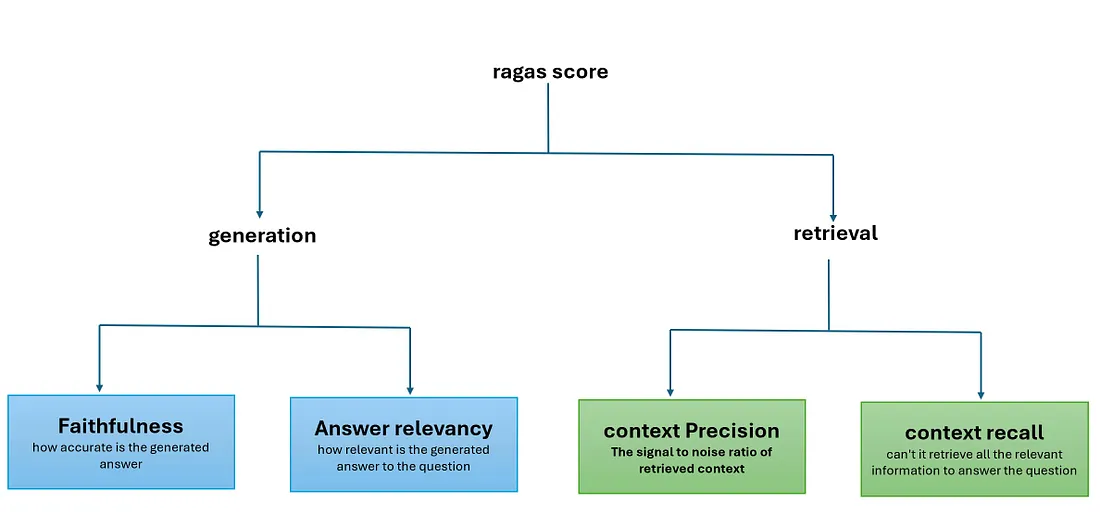

### Retrieval Metrics

- Context Precision
$$ \text{Context Precision} = \frac{\text{Número de frases pertinentes recuperadas}}{\text{Número total de sentencias recuperadas}}$$

Mide el porcentaje de fragmentos que el retriever devolvió y que efectivamente son relevantes. Un valor alto indica que casi todo lo recuperado aporta valor.

- Context Recall
$$ \text{Context Recall} = \frac{\text{Número de frases pertinentes recuperadas}}{\text{Número total de sentencias disponibles}}$$

Mide qué fracción de los fragmentos realmente relevantes fue recuperada. Un recall alto significa que el retriever no deja datos útiles sin traer.

### Generation Metrics

- Faithfulness

$$ \text{Faithfulness} = \frac{\text{Total de hechos en las respuestas}}{\text{Número total de hechos en las respuestas}}$$

Indica la proporción de afirmaciones en la respuesta que están sustentadas por el contexto recuperado. Evalúa cuánto “alinea” la salida con la fuente y evita alucinaciones.

- Answer Relevancy

$$ \text{Answer_Relevancy} = \cos(v_{respuesta}, v_{pregunta})$$

Calcula la similitud de coseno entre los embeddings de la respuesta y de la pregunta. Un valor cercano a 1 significa que la respuesta está muy enfocada en lo que el usuario preguntó.

**RAGAS SCORE** se calcula como el valor promedio de estas 4 metricas

$$\text{RAGAS SCORE}=(\text{Context Precision} + \text{Context Recall} + \text{Faithfulness}+\text{Answer_Relevancy})/4$$

Indicando el rendimiento del modelo en términos de relevancia, precisión, recall y faithfulness

[Referencia 1](https://dkaarthick.medium.com/ragas-for-rag-in-llms-a-comprehensive-guide-to-evaluation-metrics-3aca142d6e38)
[Referencia 2](https://docs.ragas.io/en/latest/getstarted/evals/#evaluating-using-a-non-llm-metric)
[Referencia 3](https://github.com/dkhundley/llm-rag-guide/blob/main/notebooks/ragas.ipynb)

[Metricas Disponibles](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/)
[Explicacion Metricas](https://medium.com/@med.el.harchaoui/rag-evaluation-metrics-explained-a-complete-guide-dbd7a3b571a8)

## Implementacion de RAGAS



Para poder evaluar definimos las métricas anteriormente descritas con ayuda de la paqueteria de RAGAS [Documentacion](https://docs.ragas.io/en/stable/)

Y lo que necesitaremos a continuación será:

- rag_chain: Proceso el cual utiliza un modelo Embedding, una base de datos vectorial, una plantilla de respuesta, un modelo Chat, devolviendo una respuesta con formato y la prediccion tal cual la realizo el modelo Chat.

Recordad que es importante definir los argumentos necesarios, sobre todo en los modelos, para poder ejecutarlos correctamente. Teniendo especial énfasis en las variables de entorno de cada modelo, ya sea Embedding o Chat.

- qa_pairs: Preguntas y Respuestas previamente generadas

- PROMP_TEMPLATE: Él le da formato al texto generado

## Aplicación - **LLM AS A JUDGE**



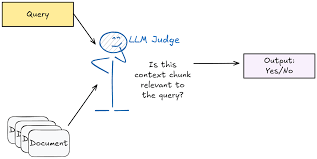

Consiste en definir primero criterios claros de evaluación (p. ej., factualidad, fluidez o relevancia) y elaborar un prompt que instruya al modelo a comparar o calificar textos según esos criterios; luego se invoca el LLM  para obtener respuestas consistentes, se parsean sus salidas estructuradas (scores y justificaciones), se agregan estadísticamente para medir desempeño global y, finalmente, se itera ajustando el prompt o parámetros para mejorar la precisión y coherencia del juez automático.

Al usar embeddings, al “LLM-as-a-Judge” le añade un paso previo de representación semántica: primero conviertes cada respuesta generada y su referencia en vectores con un wrapper de embeddings, luego mide la similitud  entre esos vectores como una métrica automática. En la llamada pasas ese objeto embeddings, y el sistema calcula para cada par candidato-referencia su puntaje de similitud basado en embeddings antes (o junto con) la revisión textual del LLM. De ese modo, tu “juez” combina juicios cualitativos del LLM con un juicio semántico cuantitativo basado en distancia de vectores, mejorando la consistencia y la sensibilidad a matices de significado.

[Referencias](https://huggingface.co/learn/cookbook/en/llm_judge)

In [178]:
CHROMA_PATH="/content/chroma_by_sections"

In [179]:
openai_api_version=API_VERSION
openai_api_key=OPENAI_API_KEY
azure_endpoint=AZURE_ENDPOINT


In [180]:
def query_rag(query_text):
    """
    Consultar un sistema de Generación Aumentada por Recuperación (RAG) usando la base de datos Chroma y OpenAI.

    Argumentos:
    - query_text (str): El texto o pregunta con el que se desea consultar el sistema RAG.

    Retorna:
    - formatted_response (str): Respuesta formateada que incluye el texto generado y las fuentes.
    - response_text (str): El texto generado como respuesta.
    """
    # Usar la misma función de embedding que antes
    embedding_function = AzureOpenAIEmbeddings(
                                  openai_api_version=API_VERSION,
                                  openai_api_key=OPENAI_API_KEY,
                                  azure_endpoint=AZURE_ENDPOINT,
                                  azure_deployment='text-embedding-ada-002',
                                  model='text-embedding-ada-002',
                                  chunk_size=460,
                                  validate_base_url=False)

    # Preparar la base de datos
    db = Chroma(persist_directory=CHROMA_PATH,
                embedding_function=embedding_function)

    # Buscar en la base de datos
    results = db.similarity_search_with_relevance_scores(query_text, k=3)

    # Verificar si hay resultados coincidentes o si la puntuación de relevancia es muy baja
    if len(results) == 0 or results[0][1] < 0.7:
        print("No se encontraron resultados relevantes.")

    # Combinar el contexto de los documentos coincidentes
    context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])

    # Crear la plantilla del prompt usando el contexto y la pregunta
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)

    # Inicializar el modelo de chat de OpenAI
    model = AzureChatOpenAI(model = 'gpt-4o',
                      azure_endpoint=AZURE_ENDPOINT,
                      api_version=API_VERSION,
                      api_key = OPENAI_API_KEY)

    # Generar el texto de respuesta a partir del prompt
    response_text = model.invoke(prompt).content

    # Obtener las fuentes de los documentos coincidentes
    sources = [doc.metadata.get("source", None) for doc, _score in results]

    # Formatear y retornar la respuesta incluyendo el texto generado y las fuentes
    formatted_response = f"Respuesta: {response_text}\nOrigen: {sources}"
    return formatted_response, response_text

**Pasamos todas las preguntas de nuestro dataset de ground truth por el RAG para sacar las respuestas predichas**

In [181]:
def evaluate_rag(rag_chain, qa_pairs):
    predictions = []
    for qa in qa_pairs:
        generated_answer = rag_chain(qa["question"])[1]
        predictions.append({
            "question": qa["question"],
            "answer": generated_answer,
            "contexts": [qa["context"]],
            "ground_truth": qa["ground_truth"]
        })
    dataset = Dataset.from_list(predictions)
    results = evaluate(
        dataset,
        metrics=[faithfulness, answer_relevancy, context_precision,context_recall],
        llm=model,
        embeddings=embedding_function,
    )
    return results

In [182]:
result_evaluation = evaluate_rag(query_rag, ground_truth[:5])

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

In [183]:
result_evaluation

{'faithfulness': 0.4857, 'answer_relevancy': 0.9373, 'context_precision': 1.0000, 'context_recall': 1.0000}

## Comparacion de distintas estrategias de trozeado

In [ ]:
# se puede hacer con menos preguntas y respuestas, actualmente tarda mas de 20 minutos con toda la data
all_results = pd.DataFrame()
for p in db_paths:
  print(p)
  CHROMA_PATH=p
  results_temp = evaluate_rag(query_rag, ground_truth[:5]).to_pandas()
  results_temp['strategy'] = p.split('/')[-1][7:]
  all_results = pd.concat([all_results,results_temp])

In [185]:
all_results.head(3)

,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_precision,context_recall,strategy
0,¿Qué son las pruebas de estrés en los programa...,[107 Las pruebas de estrés en los programas de...,"Según el contexto proporcionado, las pruebas d...",Las pruebas de estrés son uno de los pilares d...,0.0,1.000000,1.0,1.0,with_overlap
1,¿Cuál es el propósito principal de las pruebas...,[son utilizadas por bancos y reguladores con f...,"**Título del documento:** BANCO DE ESPAÑA, EST...",El propósito principal de las pruebas de estré...,1.0,0.900426,1.0,1.0,with_overlap
2,¿Por qué es importante que el sistema financie...,[nanciero a potenciales perturbaciones y que s...,Título del documento: No especificado en el co...,Es importante porque un sistema financiero sól...,1.0,0.921845,1.0,1.0,with_overlap


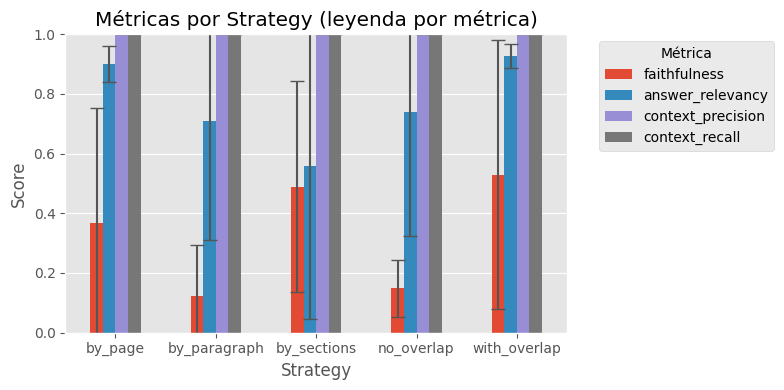

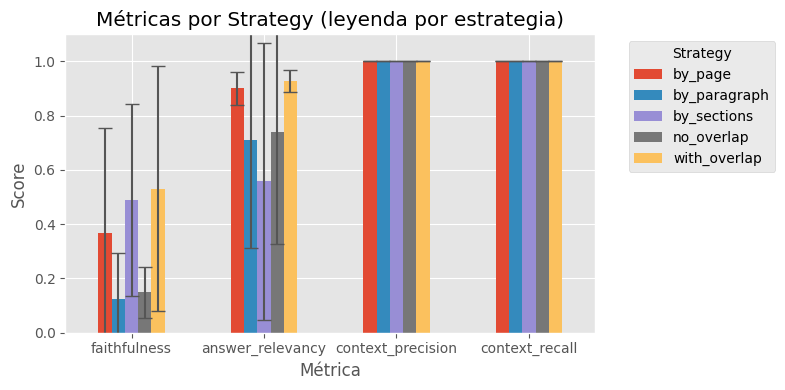

In [186]:
df = all_results.copy()

# Agrupar por estrategia y calcular media y desviación estándar
grouped = df.groupby('strategy')[['faithfulness','answer_relevancy','context_precision', 'context_recall']].agg(['mean', 'std'])
means = grouped.xs('mean', axis=1, level=1)
stds = grouped.xs('std', axis=1, level=1)

# Gráfico 1: barras por estrategia, leyenda por métrica
fig, ax = plt.subplots(figsize=(8,4))
means.plot(kind='bar', yerr=stds, capsize=5, ax=ax, rot=0)
ax.set_xlabel('Strategy')
ax.set_ylabel('Score')
ax.set_title('Métricas por Strategy (leyenda por métrica)')
ax.legend(title='Métrica', loc='upper left', bbox_to_anchor=(1.05, 1))
ax.set_ylim(0,1)
plt.tight_layout()
plt.show()

# Gráfico 2: métricas en el eje X, barras por estrategia, leyenda por estrategia
fig, ax = plt.subplots(figsize=(8,4))
means.T.plot(kind='bar', yerr=stds.T, capsize=5, ax=ax, rot=0)
ax.set_xlabel('Métrica')
ax.set_ylabel('Score')
ax.set_title('Métricas por Strategy (leyenda por estrategia)')
ax.legend(title='Strategy', loc='upper left', bbox_to_anchor=(1.05, 1))
ax.set_ylim(0,1.1)
plt.tight_layout()
plt.show()

## Métricas Personalizadas



En RAGAS puedes definir métricas personalizadas creando una subclase de Metric donde especifiques nombre, descripción y las columnas requeridas (por ejemplo "prediction" y "reference") e implementes el método evaluate que reciba una lista de ejemplos y devuelva sus puntuaciones.

Para usarla debes asegurarte de que tu EvaluationDataset (o tu dataset sintético) incluya esas columnas con los nombres correctos, y luego, al llamar a evaluate, pasar tu instancia de métrica personalizada junto con la configuración habitual de LLM (LangchainLLMWrapper), embeddings (LangchainEmbeddingsWrapper), tamaño de chunk (lote), manejo de errores y demás parámetros. Así, RAGAS podrá ejecutar tu lógica de evaluación propia dentro de su pipeline estándar.

Para incorporar métricas propias sigue estos pasos:

1. Definir el tipo de métrica

- ¿Evalúas interacciones de un solo turno o de varios giros?

    * SingleTurnMetric para pares (consulta–respuesta) independientes.

    * MultiTurnMetric si tu evaluación abarca diálogos o cadenas de intercambio.

2. Determinar las dependencias de tu métrica

  - ¿Necesitas invocar un LLM para juzgar el contenido?

    * Subclasifica MetricWithLLM en lugar de Metric.

  - ¿Vas a basarte en distancias semánticas de embeddings?

    * Subclasifica MetricWithEmbeddings.

  - ¿Ambas cosas?

    * Crea una subclase que herede de MetricWithLLM y MetricWithEmbeddings, más la variante SingleTurn o MultiTurn según corresponda.

3. Implementación paso a paso

    a. Elige la clase base adecuada (por ejemplo, class FidelityMetric(MetricWithLLM, SingleTurnMetric):).

    b. Implementa propiedades obligatorias

    c. Sobrescribe evaluate(self, examples) para aplicar tu fórmula de fidelidad (e.g. comparar cita vs. generación y penalizar omisiones o invenciones).

    d. Asegúrate de que tu EvaluationDataset ya creado incluya las columnas necesarias ("query", "prediction", "reference", etc.) o usa column_map para remapear.

Vamos a crear una métrica propia que nos indique cuanto alucina el modelo en cuestión ante el prompt y contexto que se le pasan.


In [187]:
# Define the prompt
from dataclasses import dataclass, field
from typing import Dict, Optional, Set
from ragas.metrics.base import MetricWithLLM, SingleTurnMetric
from ragas.prompt import PydanticPrompt
from ragas.metrics import MetricType, MetricOutputType
from pydantic import BaseModel
from ragas import SingleTurnSample
from ragas.llms import LangchainLLMWrapper


# Define la estructura de datos del input/output del prompt que usará el LLM:
# Input: contiene question (consulta del usuario), context (documentos recuperados), y response (respuesta generada).
# Output: se espera que el modelo LLM devuelva un score ∈ [0,1] y una explicación textual (feedback) justificando ese score.

class TechnicalAccuracyInput(BaseModel):
    question: str
    context: str
    response: str

class TechnicalAccuracyOutput(BaseModel):
    score: float
    feedback: str

# Define tu prompt
# Instrucción clara para el LLM sobre cómo evaluar.
# input_model / output_model para validación de formato.
# examples (vacío por ahora): se pueden añadir ejemplos de evaluación para few-shot prompting.

class TechnicalAccuracyPrompt(PydanticPrompt[TechnicalAccuracyInput, TechnicalAccuracyOutput]):
    instruction: str = (
        "Evalua que tanto alucina con la respuesta dada en funcion del contexto. Cuanto más alucinación, mayor valor del score y viceversa. Valor acotado entre 0 y 1."
    )
    input_model = TechnicalAccuracyInput
    output_model =  TechnicalAccuracyOutput
    examples = [
        # Add examples here
               ]

    # La métrica se declara como un dataclass y hereda de:
    # MetricWithLLM: permite usar un LLM para generar evaluaciones.
    # SingleTurnMetric: indica que esta métrica evalúa una sola ronda de interacción por ejemplo.
    # Especifica qué columnas necesita de los datos: user_input y response.

@dataclass
class TechnicalAccuracy(MetricWithLLM, SingleTurnMetric):
    name: str = "technical_accuracy"
    _required_columns: Dict[MetricType, Set[str]] = field(
        default_factory=lambda: {
            MetricType.SINGLE_TURN: {
                "user_input",
                "response",

            }
        }
    )


    output_type: Optional[MetricOutputType] = MetricOutputType.CONTINUOUS
    evaluation_prompt: PydanticPrompt = field(default_factory=TechnicalAccuracyPrompt)


    # Lógica de evaluación (_single_turn_ascore)
    # Recoge los datos del sample: pregunta, respuesta, y contexto recuperado (si existe).
    # Crea un input estructurado para el prompt LLM.
    # Invoca el LLM mediante el prompt TechnicalAccuracyPrompt, y espera que devuelva un objeto tipo TechnicalAccuracyOutput.
    # Devuelve el score del output.

    async def _single_turn_ascore(self, sample, callbacks) -> float:
        assert self.llm is not None, "LLM must be set"

        question = sample.user_input
        response = sample.response
        # Get the context
        context = "\n".join(sample.retrieved_contexts) if sample.retrieved_contexts else ""

        # Prepare input for prompt
        prompt_input = TechnicalAccuracyInput(
            question=question,
            context=context,
            response=response,
        )

        # Generate evaluation
        evaluation = await self.evaluation_prompt.generate(
            data=prompt_input, llm=self.llm, callbacks=callbacks
        )

        return evaluation.score

In [188]:
openai_api_version=API_VERSION
openai_api_key=OPENAI_API_KEY
azure_endpoint=AZURE_ENDPOINT


In [189]:
evaluator_llm = LangchainLLMWrapper(AzureChatOpenAI(model="gpt-4o",
                                                    azure_endpoint=AZURE_ENDPOINT,
                                                    api_version=API_VERSION,
                                                    api_key = OPENAI_API_KEY))

test_data = {
    "user_input": "Que son las pruebas de estress.",
    "retrieved_contexts": ["""Las pruebas de estrés consisten en la estimación del impacto de per￾turbaciones adversas excepcionales, pero verosímiles, en variables ma￾croeconómicas y financieras sobre los resultados y la solvencia de un
                              grupo de instituciones financieras. Es importante señalar, no obstante,
                              que estos ejercicios no proporcionan la probabilidad de que se produzca
                              una determinada perturbación, sino que lo que hacen es cuantificar el
                              impacto de esta. Dichas pruebas constituyen, por tanto, una herramienta
                              muy útil para valorar los riesgos y vulnerabilidades del sistema financiero.
                              Debe advertirse de que muchas instituciones financieras utilizan también
                              estos ejercicios como una herramienta en su gestión de riesgos (3)"""],
    "response": "Las pruebas de estrés consisten en la estimación del impacto de perturbaciones adversas excepcionales",
}

# Crea una muestra
sample = SingleTurnSample(**test_data)
technical_accuracy = TechnicalAccuracy(llm=evaluator_llm)
score = await technical_accuracy.single_turn_ascore(sample)
print(f"Halucination Score: {score}")

/tmp/ipython-input-2285943056.py:1: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use the modern LLM providers instead: from ragas.llms.base import llm_factory; llm = llm_factory('gpt-4o-mini') or from ragas.llms.base import instructor_llm_factory; llm = instructor_llm_factory('openai', client=openai_client)
  evaluator_llm = LangchainLLMWrapper(AzureChatOpenAI(model="gpt-4o",


Halucination Score: 0.8


Ahora aplicamos esta métrica a la salida generada por el modelo al consultar la información contenida en el RAG.

In [190]:
query_text

'Que significan las siglas FSAP'

In [191]:
context = [doc.page_content for doc, _score in results]
context

['con una ligera recuperación para el año 2012. En este caso el descenso observado en 2011 coincidió con el presentado en el escenario adverso para 2011 pero lo rebasó en 2012. 4 Por último, en el caso del Euribor, los escenarios base y adverso mostraban valores crecientes tanto en 2011 como en 2012 distanciados en 1,3 puntos en ambos casos. La evolución real se aproximó a la previsión del escenario base de 2011, pero en 2012 quedó significativamente desviada a la baja de ambos escenarios tanto en magnitud como en tendencia (con diferencias de 1,6 y 2,9 puntos).',
 'descenso de las cotizaciones bursátiles se consideró en seis países, con  un tamaño de la perturbación en un rango entre el 20% y el 40%. El au- mento en los tipos de interés, a corto y/o a largo plazo, se contempló en  cinco países, normalmente en análisis de sensibilidad, y, en estos casos,  la perturbación oscila entre los 30 y los 530 puntos básicos. El descenso  de los precios de los activos inmobiliarios fue también b

In [192]:
prompt

'Human: \nResponde la pregunta únicamente con base en el siguiente contexto:\nCiota el titulo del documento y la pagina de donde proviene la informacion.\n\ncon una ligera recuperación para el año 2012. En este caso el descenso observado en 2011 coincidió con el presentado en el escenario adverso para 2011 pero lo rebasó en 2012. 4 Por último, en el caso del Euribor, los escenarios base y adverso mostraban valores crecientes tanto en 2011 como en 2012 distanciados en 1,3 puntos en ambos casos. La evolución real se aproximó a la previsión del escenario base de 2011, pero en 2012 quedó significativamente desviada a la baja de ambos escenarios tanto en magnitud como en tendencia (con diferencias de 1,6 y 2,9 puntos).\n\n[Título: analisis_impacto_pruebas_resistencia_financiero_esp, Página: 40]\n\n---\n\ndescenso de las cotizaciones bursátiles se consideró en seis países, con  un tamaño de la perturbación en un rango entre el 20% y el 40%. El au- mento en los tipos de interés, a corto y/o a

In [193]:
response_text = model.predict(prompt)


In [194]:
openai_api_version=API_VERSION
openai_api_key=OPENAI_API_KEY
azure_endpoint=AZURE_ENDPOINT


In [195]:
evaluator_llm = LangchainLLMWrapper(AzureChatOpenAI(model="gpt-4o",
                                                    azure_endpoint=AZURE_ENDPOINT,
                                                    api_version=API_VERSION,
                                                    api_key = OPENAI_API_KEY))



/tmp/ipython-input-4263386227.py:1: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use the modern LLM providers instead: from ragas.llms.base import llm_factory; llm = llm_factory('gpt-4o-mini') or from ragas.llms.base import instructor_llm_factory; llm = instructor_llm_factory('openai', client=openai_client)
  evaluator_llm = LangchainLLMWrapper(AzureChatOpenAI(model="gpt-4o",


In [196]:
test_data = {
    "user_input": query_text,
    "retrieved_contexts": [doc.page_content for doc, _score in results],
    "response": model.predict(prompt),
}

In [197]:
# Cálculo métrica Alucinación.
sample = SingleTurnSample(**test_data)
technical_accuracy = TechnicalAccuracy(llm=evaluator_llm)
score = await technical_accuracy.single_turn_ascore(sample)
print(f"Halucination Score: {score}")

Halucination Score: 0.1


# 8: Consultar una base de datos vectorial para obtener datos relevantes.




**Pipeline Completo**

Puedes utilizar alguno de los siguientes textos, recordando que les va a devolver información siempre y cuando la pregunta o petición se encuentre en los documentos proporcionados:

- ¿Qué significan las siglas FSAP?

- ¿En qué año se estableció un programa de evaluación del sistema financiero?

- ¿Cuál es el origen y el objetivo del FSAP (Financial Sector Assessment Program)?

- ¿Qué componentes principales conforman el programa FSAP?

- ¿Cómo se definen y qué fases incluye el diseño de las pruebas de estrés?

- ¿En qué se diferencian los análisis de sensibilidad y los análisis de escenarios dentro de las pruebas de estrés?

- ¿Qué variables suelen someterse a perturbación y cómo se calibra el tamaño de la perturbación?

In [202]:
#Esta funcion de generate_rag no tiene ningun sentido aqui, porque cada vez que se esta llamando esta volviendo a aplicar una estrategia de chunks
def generate_rag(clean_func=None, metadata_func=None):
    """
    Función para generar una base de datos vectorial en Chroma a partir de documentos.
    """
    documents = load_documents()  # Cargar los documentos desde una fuente
    chunks = split_with_overlap(documents)  # Seleccionar la estrategia de troceado

    if clean_func: # si existe funcion de limpieza
      chunks = clean_func(chunks)

    if metadata_func:
      chunks = metadata_func(chunks)

    CHROMA_PATH = '/content/chroma_with_overlap/'
    save_to_chroma(chunks, CHROMA_PATH)  # Guardar los datos procesados en el almacén de datos

def answer(query_text, PROMPT_TEMPLATE=None, embedding_function=None, model=None):
    CHROMA_PATH ='/content/chroma_with_overlap/'
    if not embedding_function:
      embedding_function = AzureOpenAIEmbeddings(
                                  openai_api_version=API_VERSION,
                                  openai_api_key=OPENAI_API_KEY,
                                  azure_endpoint=AZURE_ENDPOINT,
                                  azure_deployment='text-embedding-ada-002',
                                  model='text-embedding-ada-002',
                                  chunk_size=460,
                                  validate_base_url=False)

    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)

    if not PROMPT_TEMPLATE:
      PROMPT_TEMPLATE = """
                        Responde la pregunta únicamente con base en el siguiente contexto:

                        {context}

                        Responde la pregunta con base en el contexto anterior: {question}
                        """

    results = db.similarity_search_with_relevance_scores(query_text, k=3) # k - numero de fragmentos a encontrar
    if len(results) == 0 or results[0][1] < 0.7:
        print(f"No se encontraron resultados coincidentes.")

    context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)

    if not model:
      model = AzureChatOpenAI(model = 'gpt-4o',
                      azure_endpoint=AZURE_ENDPOINT,
                      api_version=API_VERSION,
                      api_key = OPENAI_API_KEY
)

    response_text = model.invoke(prompt).content

    sources = [doc.metadata.get("source", None) for doc, _score in results]
    formatted_response = f"Response: {response_text}\n Sources: {sources}"
    print(formatted_response)

In [203]:
generate_rag()
answer("¿En que año se establecio un programa de evaluacion del sistema financiero?")

Se dividieron 63 documentos en 428 fragmentos (chunks).


InternalError: Query error: Database error: error returned from database: (code: 1032) attempt to write a readonly database

In [ ]:
answer("¿Quien fue el campeón de F1 en 2022?")